In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
import tensorflow

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten, Input, Conv2D, LSTM, GRU, BatchNormalization, MaxPooling2D, Reshape
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
from numpy.random import seed
seed(13)
tensorflow.random.set_seed(2)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive')
current_path = os.path.join(os.getcwd(), 'gdrive/MyDrive')
dataset_path = os.path.join(current_path,"speech_commands_v0_02_dataset")
path_save_downsampled = os.path.join(current_path, "speech_commands_data/downsampled_dataset")

path_save_downsampled_logmelspectrogram = os.path.join(path_save_downsampled, 'log_mel_spectrogram')


Mounted at /content/gdrive


In [ ]:
os.listdir(path_save_downsampled_logmelspectrogram)

['x_train_downsampled_logmelspectrogram_0.npy',
 'x_val_downsampled_logmelspectrogram_0.npy',
 'x_test_downsampled_logmelspectrogram_0.npy']

In [ ]:
def load_object(path_to_file):
  with open(path_to_file, "rb") as input_file:
    object = pickle.load(input_file)
  return object

def save_with_pickle(name_file, data, path_to_safe):
  with open(os.path.join(path_to_safe, name_file), "wb") as file:
      pickle.dump(data, file)

# Creation of classes

In [ ]:
downsampled_train_label = load_object(os.path.join(path_save_downsampled, 'cleaned_label_train_downsampled.pickle'))
downsampled_val_label = load_object(os.path.join(path_save_downsampled, 'cleaned_label_val_downsampled.pickle'))
downsampled_test_label = load_object(os.path.join(path_save_downsampled, 'cleaned_label_test_downsampled.pickle'))

In [ ]:
commands_unkown_word = {"bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"}
commands = np.unique(downsampled_train_label)

In [ ]:

def assign_num_to_command(commands, commands_unkown_word):
  """Assigns a number to each command. Commands belonging to commands_unkown_word
  will be assigned the same number (the last one).

  :param commands: List of all commands, including the ones that belong to
  command_unkown_word.
  :param commands_unkown_word: List of commands that belong to unknown word class.
  :return: Dictionary that maps each class with a number.
  """
  commands_numerical = {}

  c = 0
  for command in commands:
    if command not in commands_unkown_word:
      commands_numerical[str(command)] = c
      c += 1
    else:
      commands_numerical[str(command)] = len(commands) - len(commands_unkown_word)
  return(commands_numerical)

def create_label_numerical_array(labels):
  """Returns an array that has replaced the classes in "labels" by their
  assigned numbers.
  :param labels: List of labels (classes) of instances.
  :return: Array with the labels replaced by the corresponding number.
  """
  commands_numerical = assign_num_to_command(commands, commands_unkown_word)

  y_array = np.array(labels, dtype=object)
  for command in commands:
    y_array = np.where(y_array == command, commands_numerical[str(command)], y_array)
  return y_array


In [ ]:
label_train = create_label_numerical_array(downsampled_train_label)

n_classes = len(set(label_train))

# One-hot encoding
y_train = to_categorical(label_train, num_classes=n_classes)
y_val = to_categorical(create_label_numerical_array(downsampled_val_label), num_classes=n_classes)
y_test = to_categorical(create_label_numerical_array(downsampled_test_label), num_classes=n_classes)


In [ ]:
classes = set(commands) - set(commands_unkown_word)
classes = np.unique(list(classes))
classes = np.append(classes, 'unkown_word')

# Load data

In [ ]:
downsampled_train_data = np.load(os.path.join(path_save_downsampled_logmelspectrogram , 'x_train_downsampled_logmelspectrogram_0.npy'))
downsampled_val_data = np.load(os.path.join(path_save_downsampled_logmelspectrogram , 'x_val_downsampled_logmelspectrogram_0.npy'))
downsampled_test_data = np.load(os.path.join(path_save_downsampled_logmelspectrogram , 'x_test_downsampled_logmelspectrogram_0.npy'))


In [ ]:
downsampled_train_data.shape

(32660, 63, 64)

In [ ]:
# Normalize data
train_shape = np.array(downsampled_train_data).shape

x_train_flattened = downsampled_train_data.flatten()

scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train_flattened.reshape(-1, 1))

x_train = x_train_normalized.reshape(train_shape)

def normalize_data(data, scaler):
  shape = data.shape
  data_flattened = data.flatten()
  data_normalized = scaler.transform(data_flattened.reshape(-1,1))
  return data_normalized.reshape(shape)


In [ ]:
x_train.shape

(32660, 63, 64)

In [ ]:
x_val = normalize_data(downsampled_val_data, scaler)
x_test = normalize_data(downsampled_test_data, scaler)

In [ ]:

input_shape = (63,64,1)

In [ ]:
input_shape

(63, 64, 1)

# Functions for evaluating model

In [ ]:
class MetricsInfoShower:
  """Class for showing reports and graphics regarding training and test
  evaluation."""

  def __init__(self, model, h_model, x, y_true, batch_size, classes) -> None:
    self.model = model
    self.h_model = h_model
    self.last_epoch = len(self.h_model.history['loss'])
    self.batch_size = batch_size
    self.y_true = np.argmax(y_test, axis=1)
    self.y_pred = self._get_y_pred(x)
    self.classes = classes



  def _get_y_pred(self, x):
    y_pred = self.model.predict(x, batch_size=self.batch_size)
    return y_pred.argmax(axis=1)

  def show_classification_report(self):
    # Evaluación del modelo
    print("[INFO]: Evaluando el modelo...")

    # Report
    print(classification_report(self.y_true, self.y_pred, target_names=self.classes))

  def show_confusion_matrix(self):
    # Calcula la matriz de confusión
    cm = confusion_matrix(self.y_true, self.y_pred, normalize='pred')

    # Crea un gráfico de matriz de confusión utilizando seaborn
    plt.figure(figsize = (16, 16))
    ax = sns.heatmap(cm, annot=True, cmap="PuBu", fmt=".2f", xticklabels=self.classes, yticklabels=classes, vmin = 0.1 )

    # Añade etiquetas y título
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.title("Matriz de Confusión")

    plt.show()

  def show_training_loss(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["loss"], label="train_loss")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  def show_training_accuracy(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

  def show_all(self):
    self.show_training_loss()
    self.show_training_accuracy()
    self.show_classification_report()
    self.show_confusion_matrix()

### Experimento_b_gru_lme_0_00

In [ ]:
exp_b_gru_lme_0_00 = Sequential([
    GRU(128, return_sequences=False, input_shape=(63, 64), activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b_gru_lme_0_00.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x, verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b_gru_lme_0_00.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b_gru_lme_0_00.csv'))

In [ ]:
y_train.shape

(32660, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b_gru_lme_0_00 = exp_b_gru_lme_0_00.fit(x_train, y_train, batch_size=batch_size, epochs=5, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3370 - loss: 2.2430
Epoch 1: val_loss improved from inf to 0.67976, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_00.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.3372 - loss: 2.2422 - val_accuracy: 0.7973 - val_loss: 0.6798 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/5
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8157 - loss: 0.5873
Epoch 2: val_loss improved from 0.67976 to 0.51452, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_00.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8157 - loss: 0.5873 - val_accuracy: 0.8492 - val_loss: 0.5145 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/5
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8659 - loss: 0.4259
Epoch 3: val_loss improved from 0.51452 to 0.46701, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_00.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8659 - loss: 0.4258 - val_accuracy: 0.8613 - val_loss: 0.4670 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/5
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8925 - loss: 0.3398
Epoch 4: val_loss did not improve from 0.46701
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8926 - loss: 0.3397 - val_accuracy: 0.8694 - val_loss: 0.4697 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/5
1017/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9091 - loss: 0.2871
Epoch 5: val_loss improved from 0.46701 to 0.46447, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_00.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9091 - loss: 0.2870 - val_accuracy: 0.8727 - val_loss: 0.4645 - learning_rate: 6.5610e-04


In [ ]:
exp_b_gru_lme_0_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,552 (912.32 KB)

 Trainable params: 77,850 (304.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 155,702 (608.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


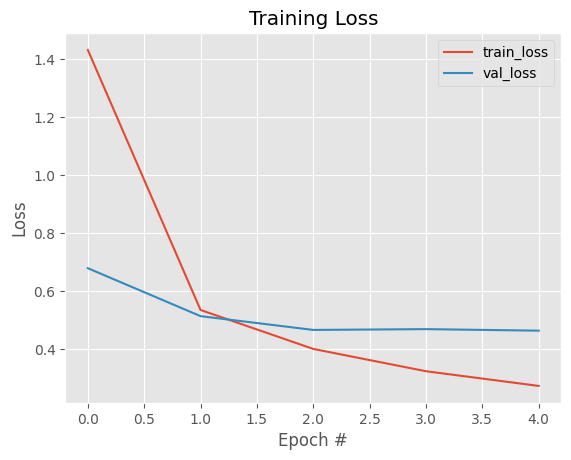

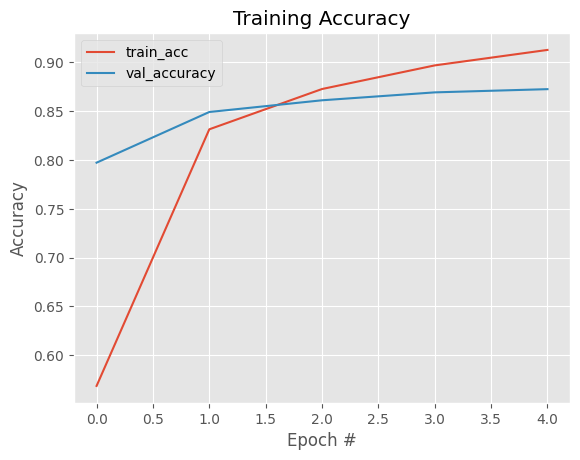

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.92      0.96      0.94       155
        down       0.91      0.83      0.87       155
       eight       0.92      0.93      0.92       155
        five       0.92      0.85      0.88       155
      follow       0.73      0.90      0.81       155
     forward       0.87      0.68      0.76       155
        four       0.73      0.85      0.79       155
          go       0.86      0.85      0.85       155
       learn       0.88      0.76      0.82       155
        left       0.94      0.88      0.91       155
        nine       0.98      0.86      0.92       155
          no       0.82      0.90      0.86       155
         off       0.90      0.92      0.91       155
          on       0.85      0.93      0.89       155
         one       0.96      0.88      0.92       155
       right       0.96      0.90      0.93       155
       seven       0.93      0.93      0.93       

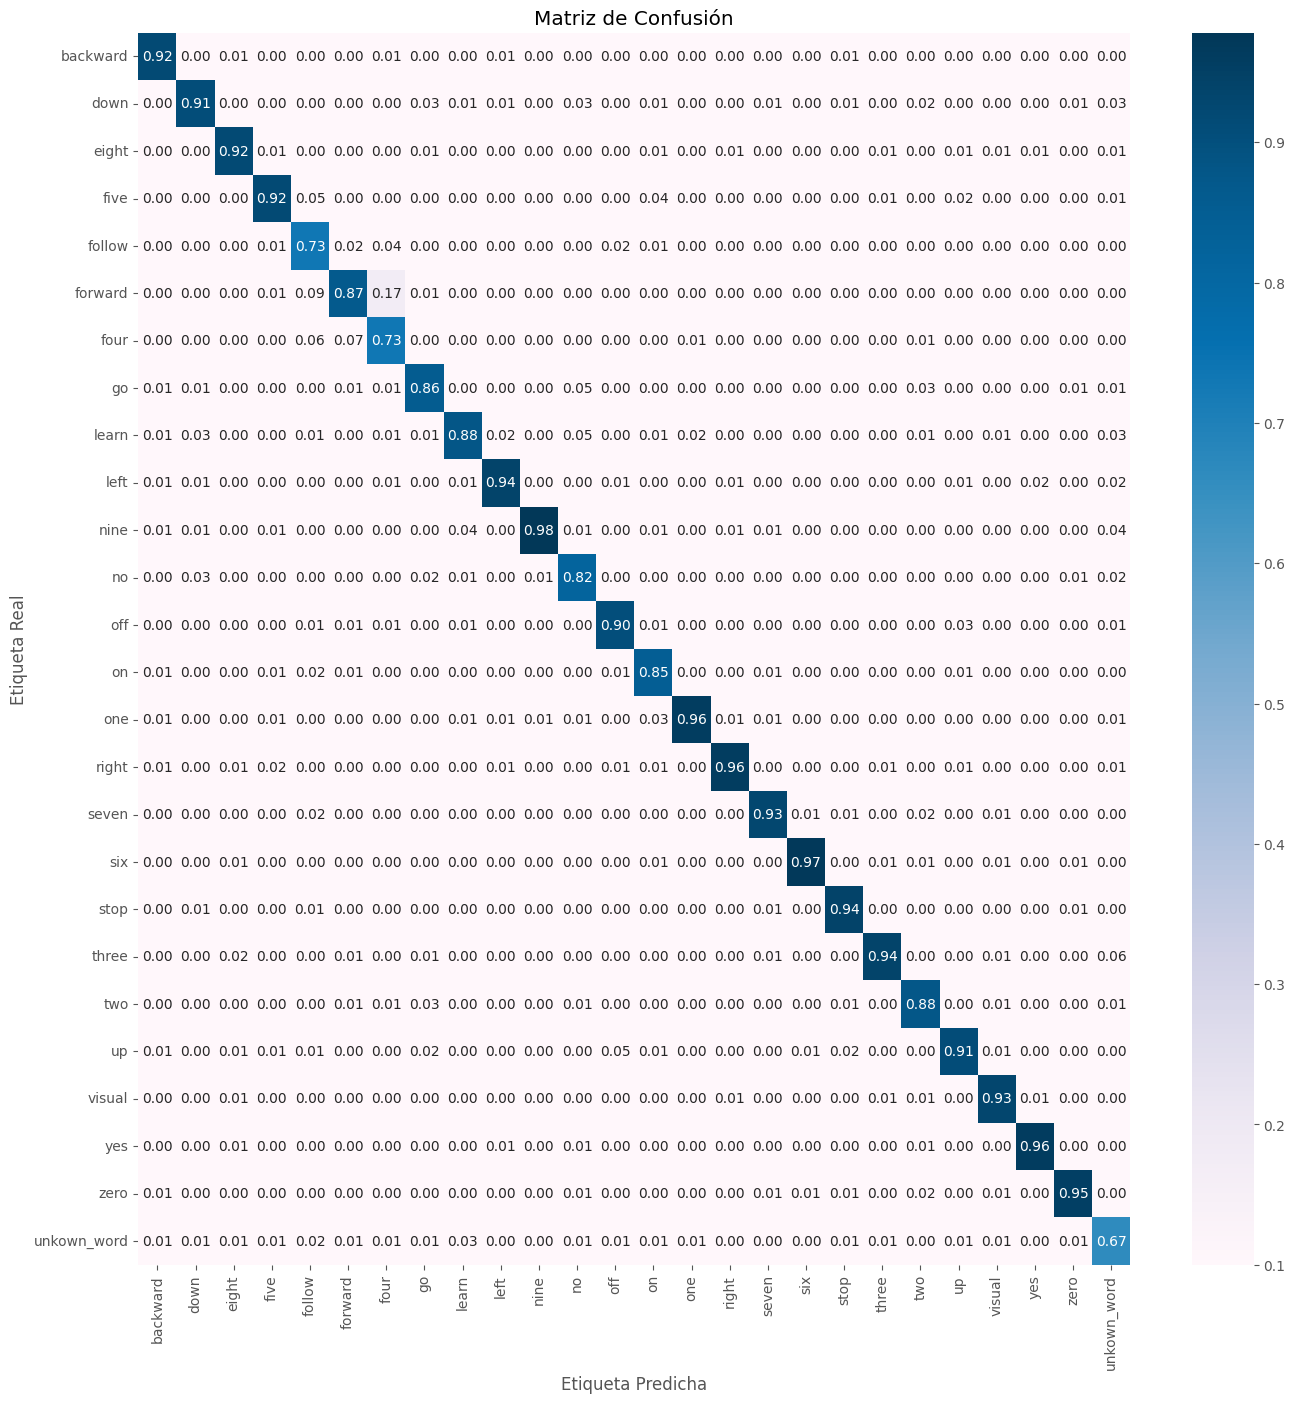

In [ ]:
mis = MetricsInfoShower(exp_b_gru_lme_0_00, h_exp_b_gru_lme_0_00, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b_gru_lme_0_01

In [ ]:
exp_b_gru_lme_0_01 = Sequential([
    GRU(64, return_sequences=False, input_shape=(63, 64), activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b_gru_lme_0_01.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b_gru_lme_0_01.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b_gru_lme_0_01.csv'))

In [ ]:
y_train.shape

(32660, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b_gru_lme_0_01 = exp_b_gru_lme_0_01.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=90,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2856 - loss: 2.4198
Epoch 1: val_loss improved from inf to 0.79950, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.2858 - loss: 2.4191 - val_accuracy: 0.7607 - val_loss: 0.7995 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1014/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7828 - loss: 0.7130
Epoch 2: val_loss improved from 0.79950 to 0.62676, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7829 - loss: 0.7126 - val_accuracy: 0.8108 - val_loss: 0.6268 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8392 - loss: 0.5233
Epoch 3: val_loss improved from 0.62676 to 0.55673, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8392 - loss: 0.5232 - val_accuracy: 0.8339 - val_loss: 0.5567 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1017/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8634 - loss: 0.4412
Epoch 4: val_loss improved from 0.55673 to 0.51102, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8634 - loss: 0.4412 - val_accuracy: 0.8508 - val_loss: 0.5110 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1015/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8803 - loss: 0.3836
Epoch 5: val_loss improved from 0.51102 to 0.50303, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8803 - loss: 0.3836 - val_accuracy: 0.8559 - val_loss: 0.5030 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1017/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8923 - loss: 0.3470
Epoch 6: val_loss improved from 0.50303 to 0.49585, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8923 - loss: 0.3470 - val_accuracy: 0.8589 - val_loss: 0.4958 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9001 - loss: 0.3188
Epoch 7: val_loss improved from 0.49585 to 0.48878, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9001 - loss: 0.3188 - val_accuracy: 0.8619 - val_loss: 0.4888 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9112 - loss: 0.2931
Epoch 8: val_loss improved from 0.48878 to 0.47566, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9112 - loss: 0.2930 - val_accuracy: 0.8673 - val_loss: 0.4757 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1017/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9165 - loss: 0.2717
Epoch 9: val_loss did not improve from 0.47566
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9165 - loss: 0.2717 - val_accuracy: 0.8658 - val_loss: 0.4798 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9212 - loss: 0.2582
Epoch 10: val_loss did not improve from 0.47566
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9212 - loss: 0.2582 - val_accuracy: 0.8640 - val_loss: 0.4802 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9254 - loss: 0.2416 - val_accuracy: 0.8703 - val_loss: 0.4697 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1015/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9295 - loss: 0.2297
Epoch 12: val_loss improved from 0.46966 to 0.45955, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9295 - loss: 0.2297 - val_accuracy: 0.8742 - val_loss: 0.4595 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9340 - loss: 0.2191
Epoch 13: val_loss did not improve from 0.45955
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9340 - loss: 0.2191 - val_accuracy: 0.8802 - val_loss: 0.4613 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9366 - loss: 0.2094
Epoch 14: val_loss improved from 0.45955 to 0.45306, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9366 - loss: 0.2094 - val_accuracy: 0.8823 - val_loss: 0.4531 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9402 - loss: 0.1989
Epoch 15: val_loss did not improve from 0.45306
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9402 - loss: 0.1989 - val_accuracy: 0.8817 - val_loss: 0.4550 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9434 - loss: 0.1919
Epoch 16: val_loss improved from 0.45306 to 0.45105, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9434 - loss: 0.1919 - val_accuracy: 0.8877 - val_loss: 0.4510 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9463 - loss: 0.1831
Epoch 17: val_loss did not improve from 0.45105
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9463 - loss: 0.1831 - val_accuracy: 0.8853 - val_loss: 0.4522 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9486 - loss: 0.1764
Epoch 18: val_loss improved from 0.45105 to 0.44863, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_01.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9486 - loss: 0.1764 - val_accuracy: 0.8856 - val_loss: 0.4486 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
1017/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9508 - loss: 0.1716
Epoch 19: val_loss did not improve from 0.44863
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9508 - loss: 0.1716 - val_accuracy: 0.8874 - val_loss: 0.4521 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
1015/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9535 - loss: 0.1646
Epoch 20: val_loss did not improve from 0.44863
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9535 - loss: 0.1646 - val_accuracy: 0.8865 - val_loss: 0.4553 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
1018/1021 ━━━━━━━━━━━━━━━━━

In [ ]:
exp_b_gru_lme_0_01.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,952 (312.32 KB)

 Trainable params: 26,650 (104.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,302 (208.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


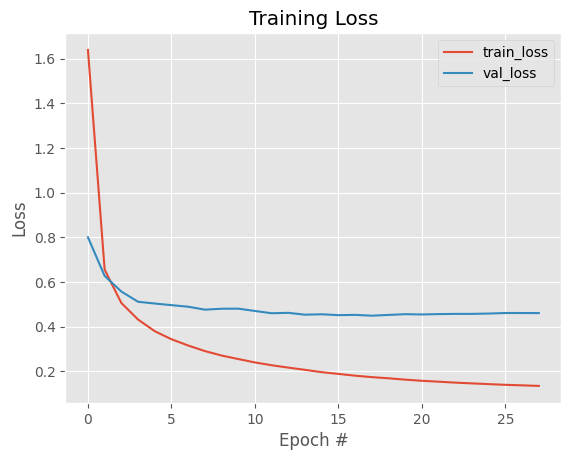

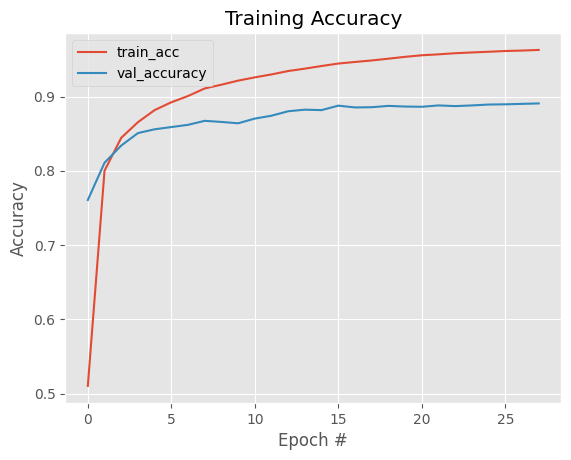

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.97      0.93      0.95       155
        down       0.87      0.81      0.84       155
       eight       0.93      0.92      0.93       155
        five       0.94      0.85      0.89       155
      follow       0.80      0.90      0.85       155
     forward       0.88      0.78      0.83       155
        four       0.79      0.84      0.81       155
          go       0.83      0.88      0.86       155
       learn       0.79      0.79      0.79       155
        left       0.85      0.91      0.88       155
        nine       0.94      0.94      0.94       155
          no       0.80      0.93      0.86       155
         off       0.95      0.89      0.92       155
          on       0.95      0.90      0.93       155
         one       0.91      0.88      0.90       155
       right       0.94      0.89      0.91       155
       seven       0.93      0.93      0.93       

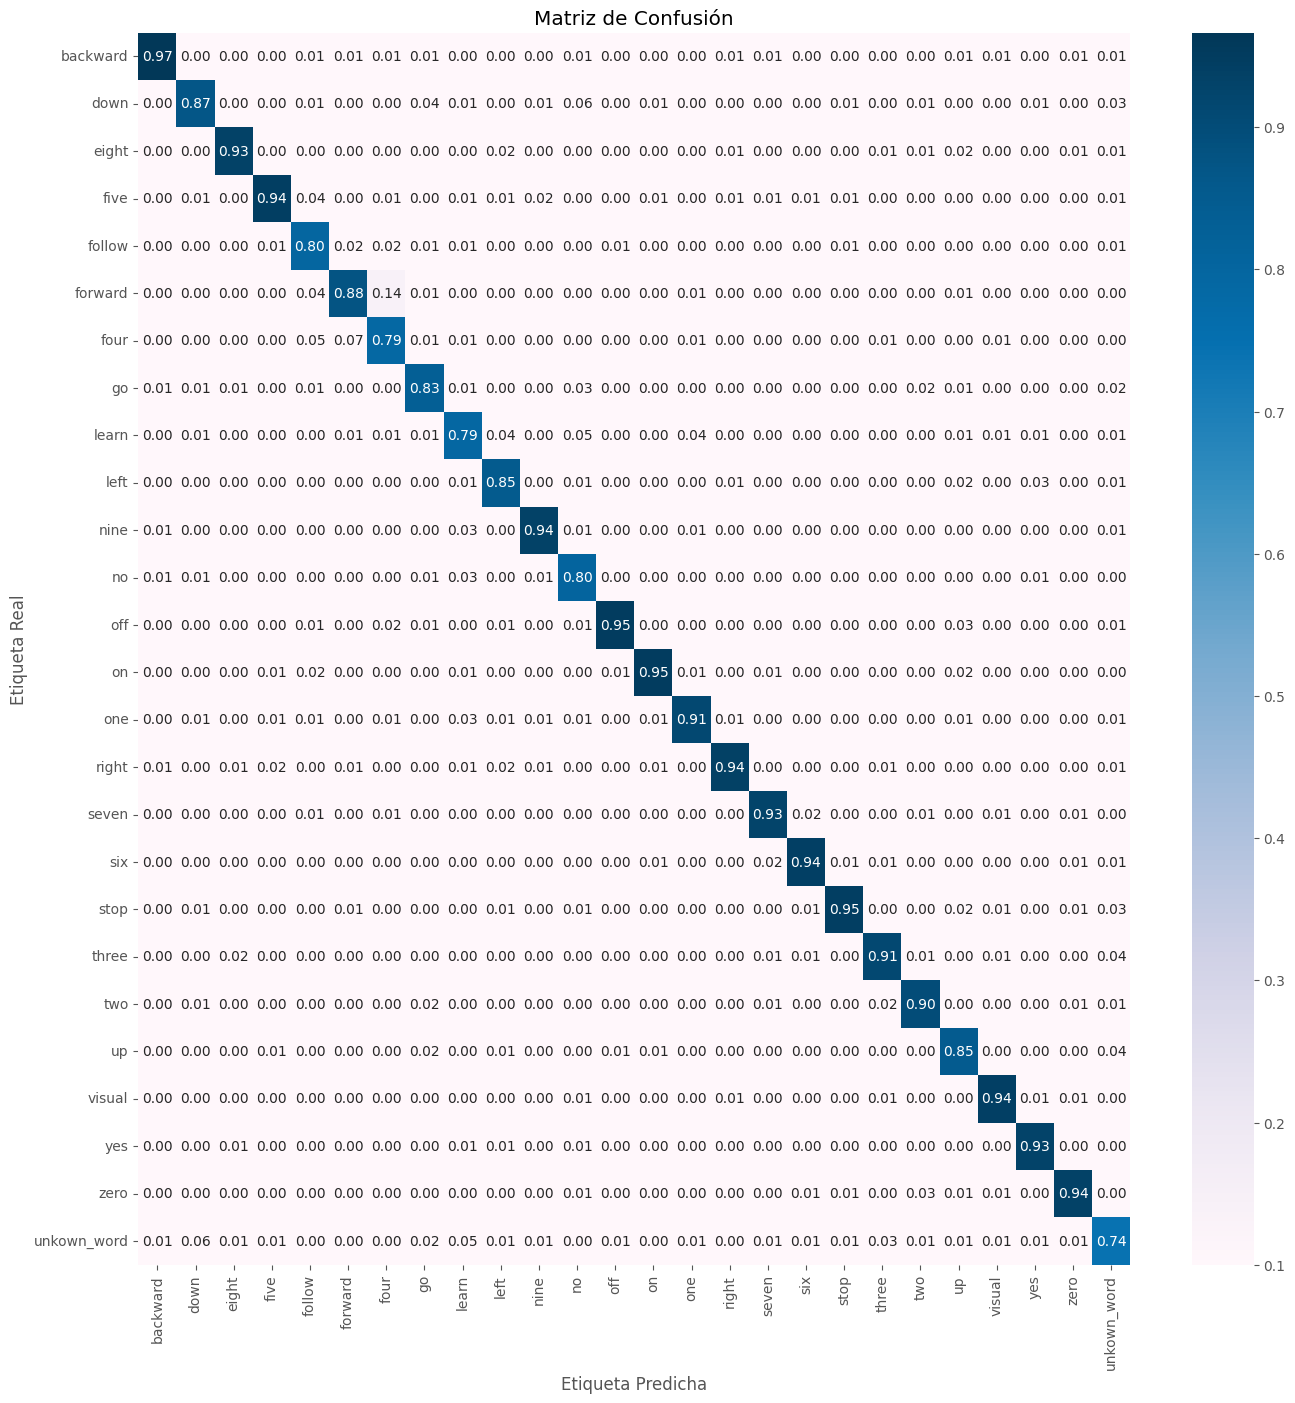

In [ ]:
mis = MetricsInfoShower(exp_b_gru_lme_0_01, h_exp_b_gru_lme_0_01, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b_gru_lme_0_02

In [ ]:
exp_b_gru_lme_0_02 = Sequential([
    GRU(32, return_sequences=False, input_shape=(63, 64), activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b_gru_lme_0_02.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b_gru_lme_0_02.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b_gru_lme_0_02.csv'))

In [ ]:
y_train.shape

(32660, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b_gru_lme_0_02 = exp_b_gru_lme_0_02.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1664 - loss: 2.8360
Epoch 1: val_loss improved from inf to 1.28801, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.1665 - loss: 2.8354 - val_accuracy: 0.6153 - val_loss: 1.2880 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6753 - loss: 1.0975
Epoch 2: val_loss improved from 1.28801 to 0.88139, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.6754 - loss: 1.0973 - val_accuracy: 0.7414 - val_loss: 0.8814 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1014/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7561 - loss: 0.8087
Epoch 3: val_loss improved from 0.88139 to 0.77220, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7562 - loss: 0.8085 - val_accuracy: 0.7703 - val_loss: 0.7722 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7891 - loss: 0.6886
Epoch 4: val_loss improved from 0.77220 to 0.72157, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7892 - loss: 0.6885 - val_accuracy: 0.7793 - val_loss: 0.7216 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1017/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8111 - loss: 0.6159
Epoch 5: val_loss improved from 0.72157 to 0.67299, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8111 - loss: 0.6158 - val_accuracy: 0.7958 - val_loss: 0.6730 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8245 - loss: 0.5697
Epoch 6: val_loss improved from 0.67299 to 0.64321, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8245 - loss: 0.5696 - val_accuracy: 0.8051 - val_loss: 0.6432 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8368 - loss: 0.5341
Epoch 7: val_loss improved from 0.64321 to 0.61825, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8368 - loss: 0.5341 - val_accuracy: 0.8138 - val_loss: 0.6182 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8448 - loss: 0.5052
Epoch 8: val_loss improved from 0.61825 to 0.60511, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8448 - loss: 0.5052 - val_accuracy: 0.8171 - val_loss: 0.6051 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8524 - loss: 0.4826
Epoch 9: val_loss improved from 0.60511 to 0.59733, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8524 - loss: 0.4825 - val_accuracy: 0.8198 - val_loss: 0.5973 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8587 - loss: 0.4623
Epoch 10: val_loss improved from 0.59733 to 0.58552, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8587 - loss: 0.4623 - val_accuracy: 0.8264 - val_loss: 0.5855 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8638 - loss: 0.4459
Epoch 11: val_loss improved from 0.58552 to 0.57982, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8638 - loss: 0.4459 - val_accuracy: 0.8297 - val_loss: 0.5798 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8679 - loss: 0.4319
Epoch 12: val_loss improved from 0.57982 to 0.57474, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8679 - loss: 0.4319 - val_accuracy: 0.8321 - val_loss: 0.5747 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1015/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8717 - loss: 0.4196
Epoch 13: val_loss improved from 0.57474 to 0.56726, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8717 - loss: 0.4196 - val_accuracy: 0.8336 - val_loss: 0.5673 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8749 - loss: 0.4084
Epoch 14: val_loss improved from 0.56726 to 0.55939, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8749 - loss: 0.4083 - val_accuracy: 0.8381 - val_loss: 0.5594 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8800 - loss: 0.3990
Epoch 15: val_loss improved from 0.55939 to 0.55250, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8800 - loss: 0.3989 - val_accuracy: 0.8414 - val_loss: 0.5525 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8820 - loss: 0.3908
Epoch 16: val_loss improved from 0.55250 to 0.54690, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8820 - loss: 0.3908 - val_accuracy: 0.8423 - val_loss: 0.5469 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8845 - loss: 0.3836
Epoch 17: val_loss improved from 0.54690 to 0.54267, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8845 - loss: 0.3836 - val_accuracy: 0.8447 - val_loss: 0.5427 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
1017/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8870 - loss: 0.3772
Epoch 18: val_loss improved from 0.54267 to 0.53953, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8870 - loss: 0.3772 - val_accuracy: 0.8465 - val_loss: 0.5395 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8885 - loss: 0.3713
Epoch 19: val_loss improved from 0.53953 to 0.53754, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8885 - loss: 0.3713 - val_accuracy: 0.8483 - val_loss: 0.5375 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8907 - loss: 0.3662
Epoch 20: val_loss improved from 0.53754 to 0.53549, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8907 - loss: 0.3662 - val_accuracy: 0.8523 - val_loss: 0.5355 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8918 - loss: 0.3616
Epoch 21: val_loss improved from 0.53549 to 0.53466, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8918 - loss: 0.3615 - val_accuracy: 0.8502 - val_loss: 0.5347 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8934 - loss: 0.3576
Epoch 22: val_loss improved from 0.53466 to 0.53392, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8934 - loss: 0.3576 - val_accuracy: 0.8520 - val_loss: 0.5339 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8945 - loss: 0.3540
Epoch 23: val_loss improved from 0.53392 to 0.53291, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8945 - loss: 0.3540 - val_accuracy: 0.8535 - val_loss: 0.5329 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8955 - loss: 0.3511
Epoch 24: val_loss improved from 0.53291 to 0.53191, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8955 - loss: 0.3510 - val_accuracy: 0.8541 - val_loss: 0.5319 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
1014/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8969 - loss: 0.3478
Epoch 25: val_loss did not improve from 0.53191
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8969 - loss: 0.3478 - val_accuracy: 0.8547 - val_loss: 0.5324 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
1014/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8971 - loss: 0.3454
Epoch 26: val_loss improved from 0.53191 to 0.53079, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8971 - loss: 0.3453 - val_accuracy: 0.8562 - val_loss: 0.5308 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8979 - loss: 0.3428
Epoch 27: val_loss did not improve from 0.53079
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8979 - loss: 0.3428 - val_accuracy: 0.8559 - val_loss: 0.5310 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
1017/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8987 - loss: 0.3408
Epoch 28: val_loss improved from 0.53079 to 0.53049, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8986 - loss: 0.3407 - val_accuracy: 0.8571 - val_loss: 0.5305 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8991 - loss: 0.3388
Epoch 29: val_loss improved from 0.53049 to 0.53024, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8991 - loss: 0.3388 - val_accuracy: 0.8574 - val_loss: 0.5302 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
1014/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8991 - loss: 0.3372
Epoch 30: val_loss improved from 0.53024 to 0.52960, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8991 - loss: 0.3371 - val_accuracy: 0.8583 - val_loss: 0.5296 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8997 - loss: 0.3356
Epoch 31: val_loss improved from 0.52960 to 0.52937, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8997 - loss: 0.3356 - val_accuracy: 0.8592 - val_loss: 0.5294 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
1015/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9003 - loss: 0.3341
Epoch 32: val_loss improved from 0.52937 to 0.52872, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9003 - loss: 0.3341 - val_accuracy: 0.8592 - val_loss: 0.5287 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9008 - loss: 0.3327
Epoch 33: val_loss did not improve from 0.52872
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9008 - loss: 0.3327 - val_accuracy: 0.8589 - val_loss: 0.5287 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
1017/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9012 - loss: 0.3315
Epoch 34: val_loss improved from 0.52872 to 0.52844, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9012 - loss: 0.3315 - val_accuracy: 0.8586 - val_loss: 0.5284 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9017 - loss: 0.3304
Epoch 35: val_loss did not improve from 0.52844
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9017 - loss: 0.3304 - val_accuracy: 0.8592 - val_loss: 0.5286 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9022 - loss: 0.3294
Epoch 36: val_loss improved from 0.52844 to 0.52838, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_02.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9022 - loss: 0.3294 - val_accuracy: 0.8589 - val_loss: 0.5284 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9023 - loss: 0.3285
Epoch 37: val_loss did not improve from 0.52838
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9023 - loss: 0.3285 - val_accuracy: 0.8586 - val_loss: 0.5287 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
1016/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9025 - loss: 0.3277
Epoch 38: val_loss did not improve from 0.52838
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9025 - loss: 0.3277 - val_accuracy: 0.8580 - val_loss: 0.5286 - learning_rate: 2.0276e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.824800363140075e-05.
Epoch 39/90
1020/1021 ━━━━━━━━━━━━━━━━━━

In [ ]:
exp_b_gru_lme_0_02.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,800 (120.32 KB)

 Trainable params: 10,266 (40.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,534 (80.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


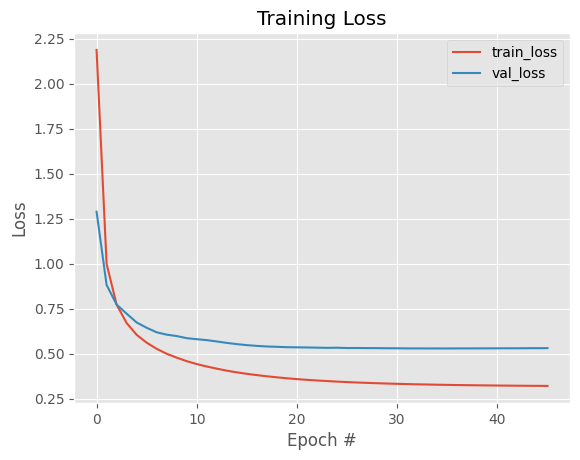

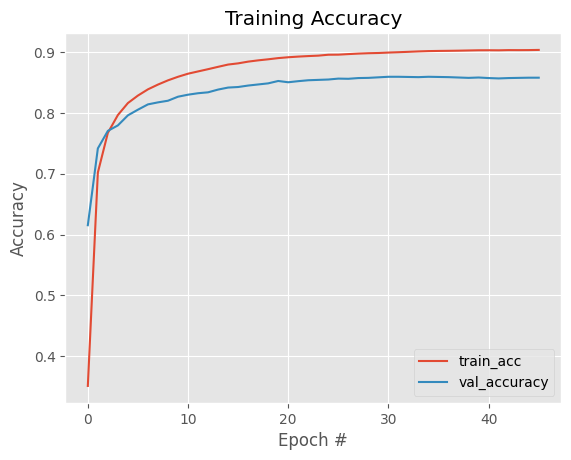

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.85      0.92      0.88       155
        down       0.85      0.83      0.84       155
       eight       0.88      0.92      0.90       155
        five       0.90      0.78      0.84       155
      follow       0.79      0.83      0.81       155
     forward       0.77      0.77      0.77       155
        four       0.74      0.77      0.75       155
          go       0.82      0.81      0.81       155
       learn       0.82      0.74      0.78       155
        left       0.88      0.86      0.87       155
        nine       0.91      0.90      0.91       155
          no       0.83      0.85      0.84       155
         off       0.88      0.88      0.88       155
          on       0.88      0.87      0.88       155
         one       0.85      0.88      0.86       155
       right       0.96      0.87      0.92       155
       seven       0.90      0.97      0.93       

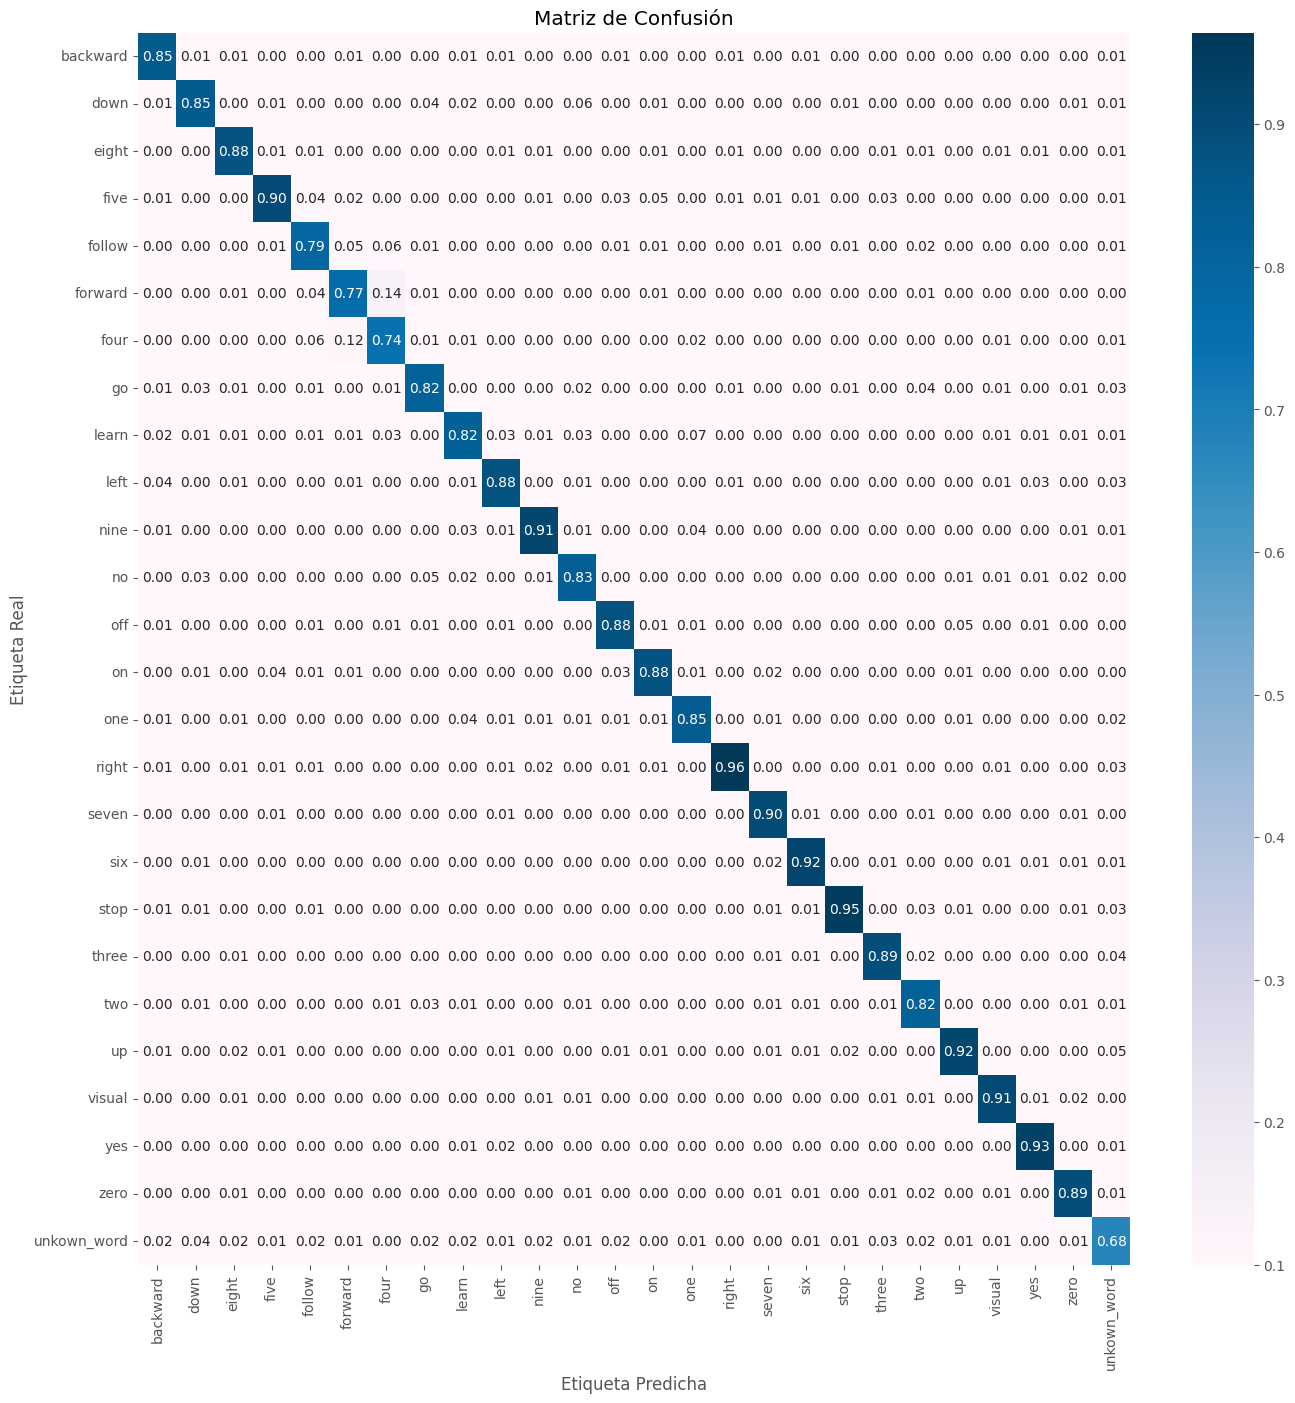

In [ ]:
mis = MetricsInfoShower(exp_b_gru_lme_0_02, h_exp_b_gru_lme_0_02, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b_gru_lme_0_03

In [ ]:
exp_b_gru_lme_0_03 = Sequential([
    GRU(64, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.2),
    GRU(64, return_sequences=False, activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b_gru_lme_0_03.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b_gru_lme_0_03.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b_gru_lme_0_03.csv'))

In [ ]:
y_train.shape

(32660, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b_gru_lme_0_03 = exp_b_gru_lme_0_03.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3093 - loss: 2.3313
Epoch 1: val_loss improved from inf to 0.72489, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_03.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.3096 - loss: 2.3305 - val_accuracy: 0.7796 - val_loss: 0.7249 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7937 - loss: 0.6689
Epoch 2: val_loss improved from 0.72489 to 0.55322, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_03.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7937 - loss: 0.6687 - val_accuracy: 0.8210 - val_loss: 0.5532 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8439 - loss: 0.4980
Epoch 3: val_loss improved from 0.55322 to 0.47997, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_03.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8439 - loss: 0.4979 - val_accuracy: 0.8526 - val_loss: 0.4800 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8690 - loss: 0.4147
Epoch 4: val_loss improved from 0.47997 to 0.44733, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_03.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8691 - loss: 0.4146 - val_accuracy: 0.8655 - val_loss: 0.4473 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8842 - loss: 0.3674
Epoch 5: val_loss improved from 0.44733 to 0.42238, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_03.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8842 - loss: 0.3673 - val_accuracy: 0.8715 - val_loss: 0.4224 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8966 - loss: 0.3234
Epoch 6: val_loss did not improve from 0.42238
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8966 - loss: 0.3234 - val_accuracy: 0.8721 - val_loss: 0.4238 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9051 - loss: 0.2953
Epoch 7: val_loss improved from 0.42238 to 0.38884, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_03.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9051 - loss: 0.2953 - val_accuracy: 0.8829 - val_loss: 0.3888 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9148 - loss: 0.2697
Epoch 8: val_loss did not improve from 0.38884
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9148 - loss: 0.2697 - val_accuracy: 0.8826 - val_loss: 0.3918 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9197 - loss: 0.2487
Epoch 9: val_loss improved from 0.38884 to 0.38145, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_03.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9197 - loss: 0.2487 - val_accuracy: 0.8928 - val_loss: 0.3814 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9268 - loss: 0.2296
Epoch 10: val_loss improved from 0.38145 to 0.36869, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_03.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9268 - loss: 0.2296 - val_accuracy: 0.8922 - val_loss: 0.3687 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9318 - loss: 0.2164
Epoch 11: val_loss improved from 0.36869 to 0.36178, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_03.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9318 - loss: 0.2163 - val_accuracy: 0.8958 - val_loss: 0.3618 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9369 - loss: 0.1984
Epoch 12: val_loss did not improve from 0.36178
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9369 - loss: 0.1984 - val_accuracy: 0.8952 - val_loss: 0.3702 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9402 - loss: 0.1889
Epoch 13: val_loss did not improve from 0.36178
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9402 - loss: 0.1889 - val_accuracy: 0.8991 - val_loss: 0.3673 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1021/1021 ━━━━━━━━━━━━

In [ ]:
exp_b_gru_lme_0_03.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 63, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,832 (604.82 KB)

 Trainable params: 51,610 (201.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,222 (403.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


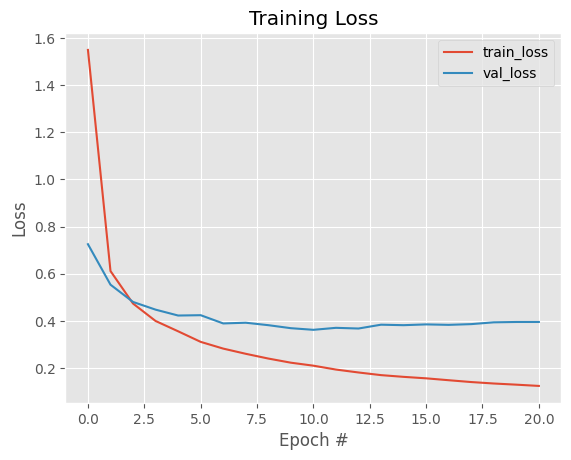

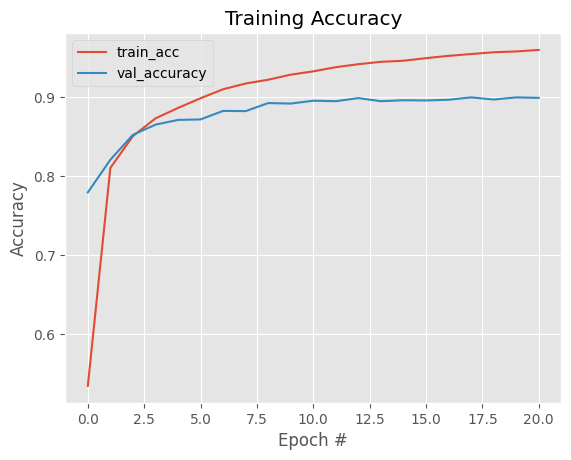

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.91      0.95      0.93       155
        down       0.95      0.79      0.87       155
       eight       0.93      0.90      0.91       155
        five       0.91      0.83      0.87       155
      follow       0.82      0.83      0.82       155
     forward       0.88      0.74      0.80       155
        four       0.70      0.84      0.76       155
          go       0.81      0.85      0.83       155
       learn       0.90      0.81      0.85       155
        left       0.93      0.92      0.92       155
        nine       0.96      0.91      0.93       155
          no       0.82      0.92      0.87       155
         off       0.96      0.90      0.93       155
          on       0.89      0.90      0.89       155
         one       0.92      0.92      0.92       155
       right       0.95      0.92      0.93       155
       seven       0.91      0.92      0.91       

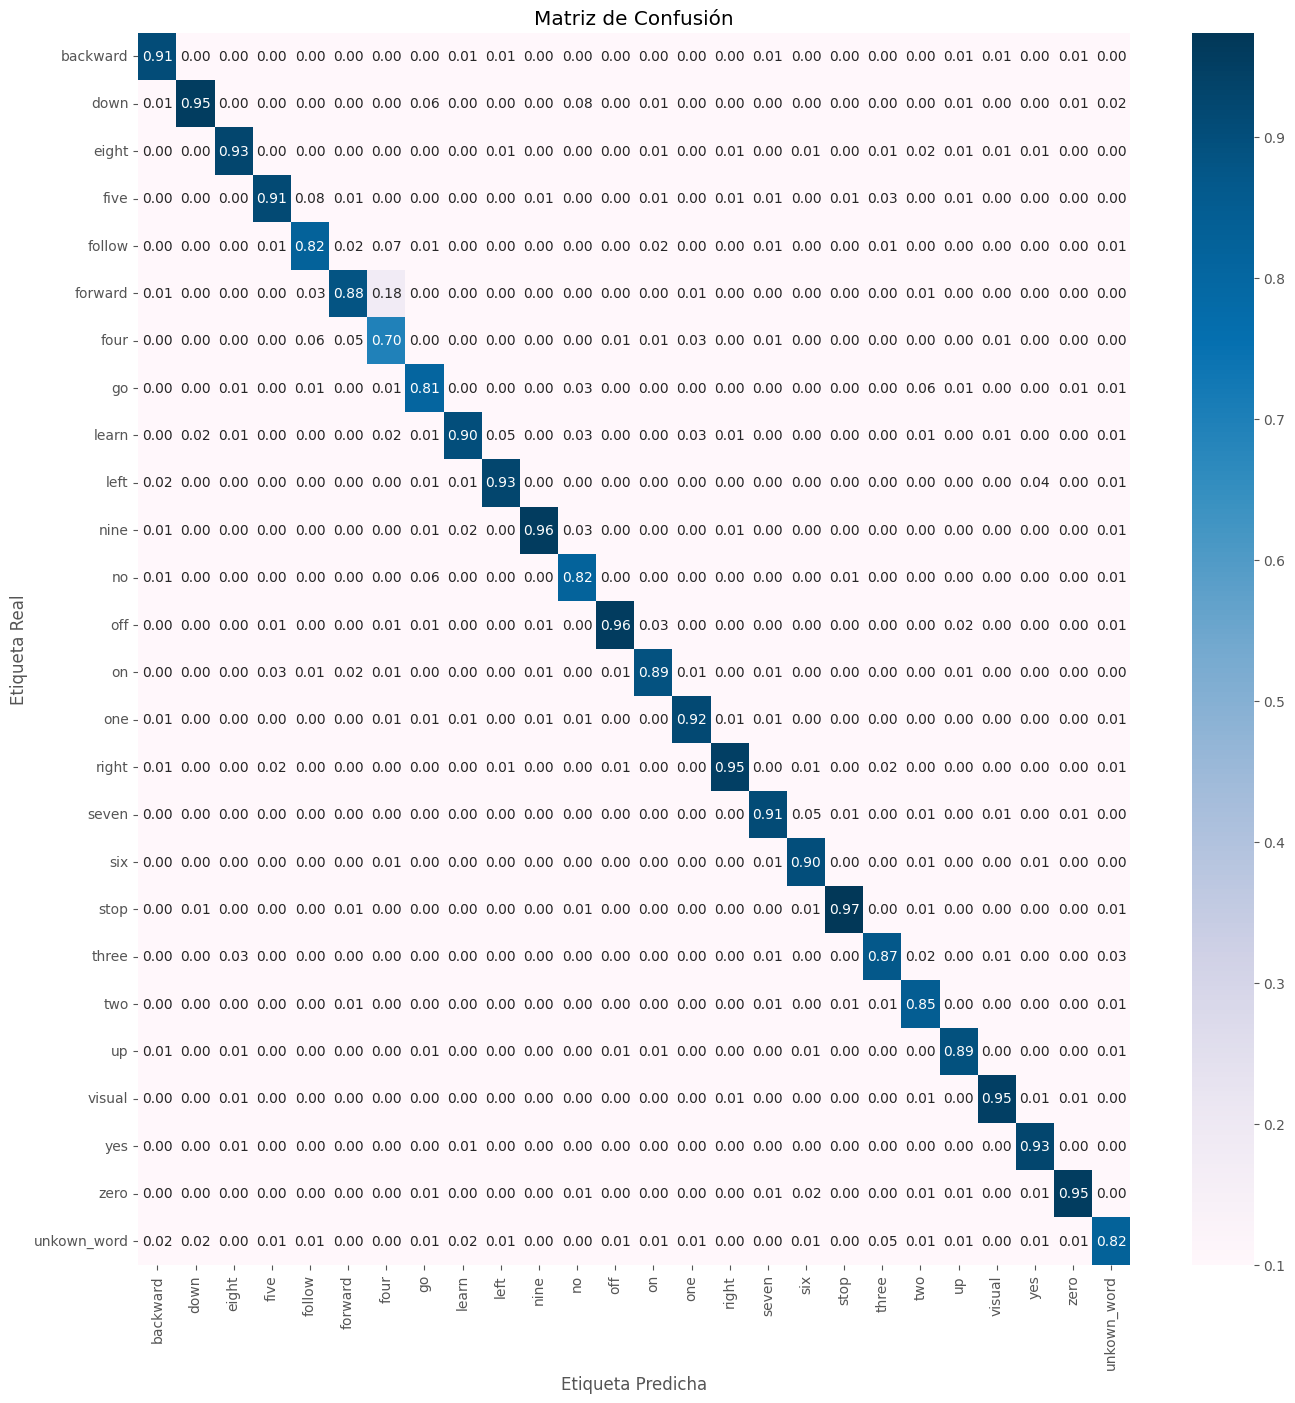

In [ ]:
mis = MetricsInfoShower(exp_b_gru_lme_0_03, h_exp_b_gru_lme_0_03, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b_gru_lme_0_04

In [ ]:
exp_b_gru_lme_0_04 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.2),
    GRU(128, return_sequences=False, activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b_gru_lme_0_04.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b_gru_lme_0_04.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b_gru_lme_0_04.csv'))

In [ ]:
y_train.shape

(32660, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b_gru_lme_0_04 = exp_b_gru_lme_0_04.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3678 - loss: 2.1287
Epoch 1: val_loss improved from inf to 0.55159, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_04.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.3681 - loss: 2.1279 - val_accuracy: 0.8393 - val_loss: 0.5516 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8322 - loss: 0.5339
Epoch 2: val_loss improved from 0.55159 to 0.42954, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_04.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8323 - loss: 0.5338 - val_accuracy: 0.8706 - val_loss: 0.4295 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8803 - loss: 0.3806
Epoch 3: val_loss improved from 0.42954 to 0.39525, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_04.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8803 - loss: 0.3805 - val_accuracy: 0.8835 - val_loss: 0.3953 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9032 - loss: 0.3042
Epoch 4: val_loss improved from 0.39525 to 0.35014, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_04.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9033 - loss: 0.3042 - val_accuracy: 0.8952 - val_loss: 0.3501 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9215 - loss: 0.2476
Epoch 5: val_loss did not improve from 0.35014
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9215 - loss: 0.2476 - val_accuracy: 0.8916 - val_loss: 0.3679 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1018/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9301 - loss: 0.2149
Epoch 6: val_loss improved from 0.35014 to 0.34913, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_04.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9301 - loss: 0.2148 - val_accuracy: 0.8961 - val_loss: 0.3491 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9399 - loss: 0.1834
Epoch 7: val_loss did not improve from 0.34913
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9399 - loss: 0.1834 - val_accuracy: 0.9042 - val_loss: 0.3597 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9532 - loss: 0.1532
Epoch 8: val_loss improved from 0.34913 to 0.33920, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_04.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9532 - loss: 0.1532 - val_accuracy: 0.9102 - val_loss: 0.3392 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9559 - loss: 0.1391
Epoch 9: val_loss did not improve from 0.33920
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9559 - loss: 0.1391 - val_accuracy: 0.9048 - val_loss: 0.3681 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9625 - loss: 0.1193
Epoch 10: val_loss did not improve from 0.33920
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9625 - loss: 0.1193 - val_accuracy: 0.9078 - val_loss: 0.3782 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1018/1021 ━━━━━━━━━━━━━━━

In [ ]:
exp_b_gru_lme_0_04.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                          │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 530,768 (2.02 MB)

 Trainable params: 176,922 (691.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 353,846 (1.35 MB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


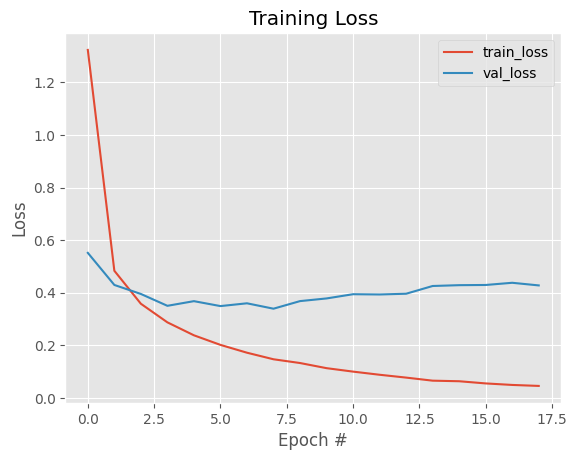

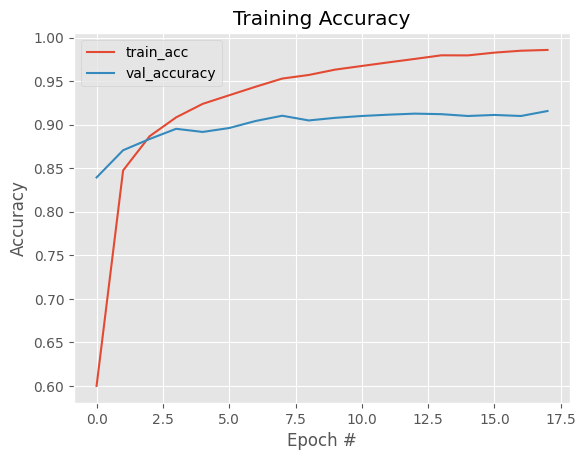

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.92      0.94      0.93       155
        down       0.91      0.90      0.91       155
       eight       0.95      0.90      0.92       155
        five       0.91      0.92      0.92       155
      follow       0.89      0.90      0.90       155
     forward       0.92      0.81      0.86       155
        four       0.80      0.89      0.84       155
          go       0.85      0.94      0.89       155
       learn       0.92      0.81      0.86       155
        left       0.90      0.90      0.90       155
        nine       0.98      0.96      0.97       155
          no       0.90      0.95      0.93       155
         off       0.95      0.92      0.93       155
          on       0.93      0.89      0.91       155
         one       0.93      0.93      0.93       155
       right       0.94      0.94      0.94       155
       seven       0.96      0.97      0.97       

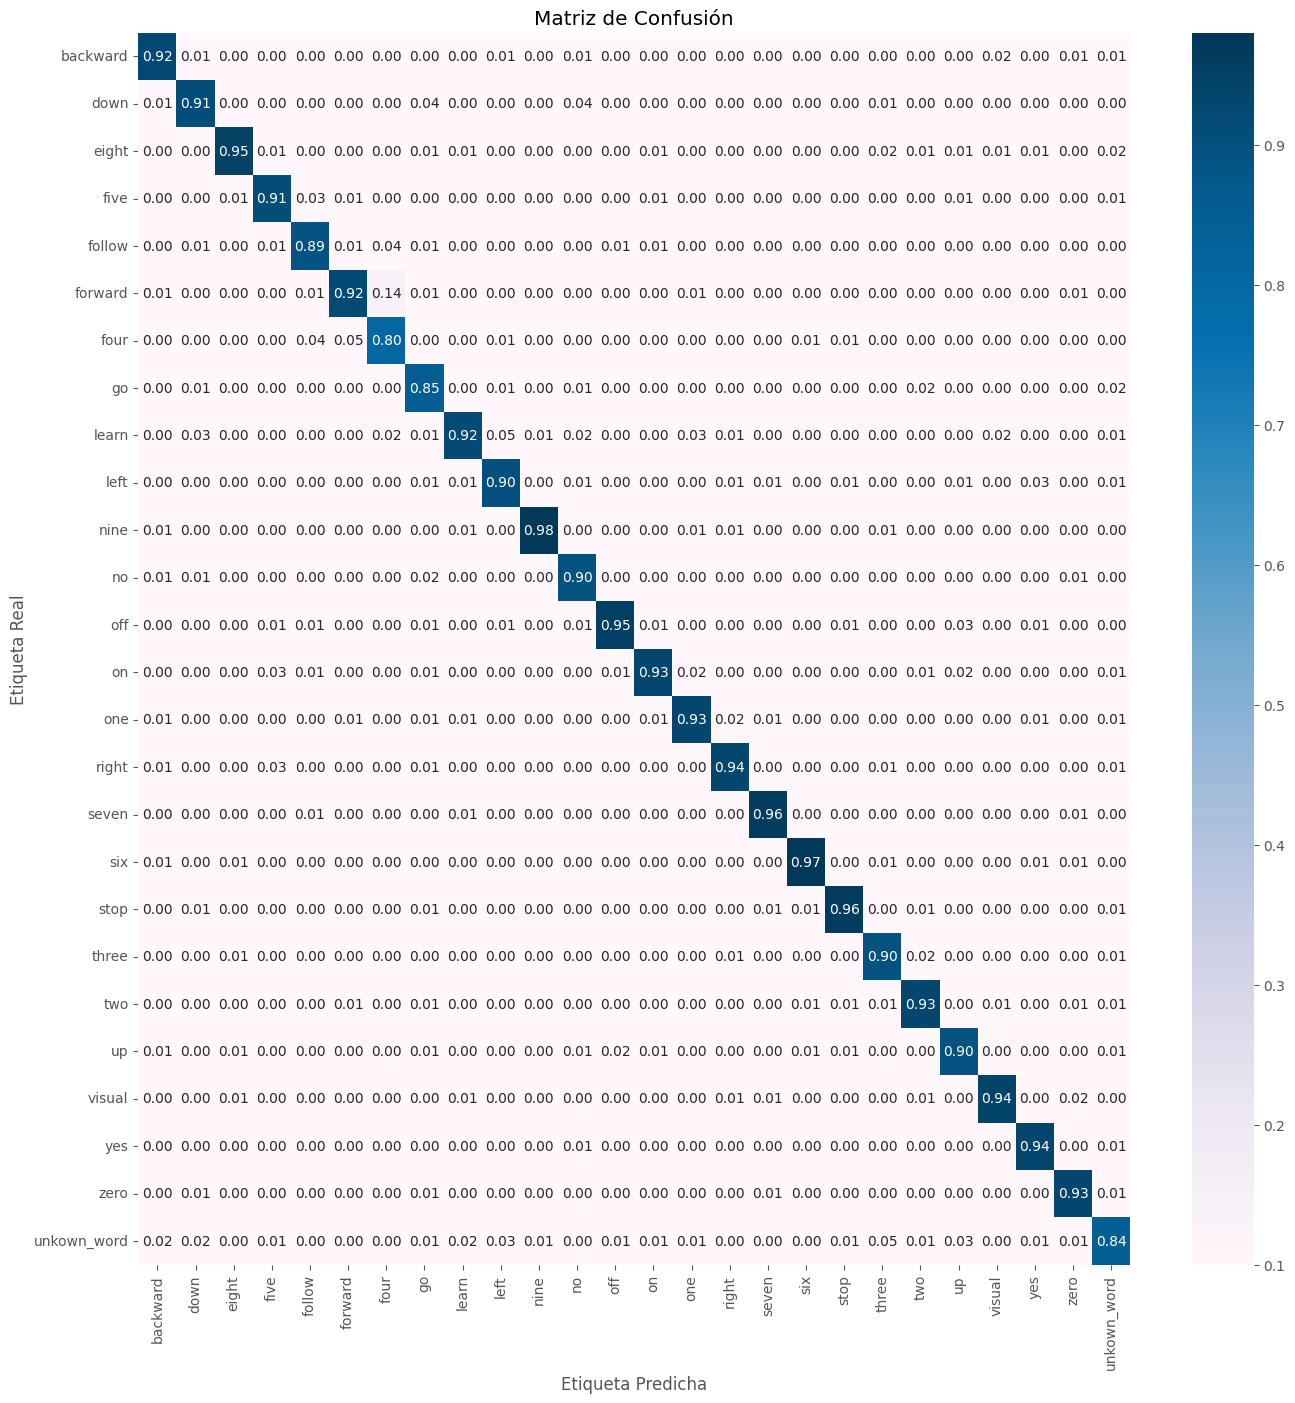

In [ ]:
mis = MetricsInfoShower(exp_b_gru_lme_0_04, h_exp_b_gru_lme_0_04, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b_gru_lme_0_05

In [ ]:
exp_b_gru_lme_0_05 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.4),
    GRU(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    GRU(32, return_sequences=False, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b_gru_lme_0_05.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b_gru_lme_0_05.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b_gru_lme_0_05.csv'))

In [ ]:
y_train.shape

(32660, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b_gru_lme_0_05 = exp_b_gru_lme_0_05.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2093 - loss: 2.6621
Epoch 1: val_loss improved from inf to 0.95053, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.2095 - loss: 2.6614 - val_accuracy: 0.7099 - val_loss: 0.9505 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7218 - loss: 0.9212
Epoch 2: val_loss improved from 0.95053 to 0.65820, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.7219 - loss: 0.9211 - val_accuracy: 0.8060 - val_loss: 0.6582 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7999 - loss: 0.6688
Epoch 3: val_loss improved from 0.65820 to 0.57171, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7999 - loss: 0.6688 - val_accuracy: 0.8312 - val_loss: 0.5717 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8390 - loss: 0.5441
Epoch 4: val_loss improved from 0.57171 to 0.49400, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8390 - loss: 0.5440 - val_accuracy: 0.8562 - val_loss: 0.4940 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8604 - loss: 0.4665
Epoch 5: val_loss did not improve from 0.49400
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8604 - loss: 0.4665 - val_accuracy: 0.8628 - val_loss: 0.5043 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8811 - loss: 0.4014
Epoch 6: val_loss improved from 0.49400 to 0.46761, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8811 - loss: 0.4014 - val_accuracy: 0.8733 - val_loss: 0.4676 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8923 - loss: 0.3657
Epoch 7: val_loss improved from 0.46761 to 0.42812, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8923 - loss: 0.3656 - val_accuracy: 0.8850 - val_loss: 0.4281 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9051 - loss: 0.3206
Epoch 8: val_loss did not improve from 0.42812
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.9051 - loss: 0.3206 - val_accuracy: 0.8844 - val_loss: 0.4465 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9139 - loss: 0.2958
Epoch 9: val_loss improved from 0.42812 to 0.41771, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9139 - loss: 0.2958 - val_accuracy: 0.8874 - val_loss: 0.4177 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9194 - loss: 0.2781
Epoch 10: val_loss improved from 0.41771 to 0.40576, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9194 - loss: 0.2780 - val_accuracy: 0.8928 - val_loss: 0.4058 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9232 - loss: 0.2519
Epoch 11: val_loss improved from 0.40576 to 0.39761, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.9232 - loss: 0.2519 - val_accuracy: 0.8952 - val_loss: 0.3976 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9282 - loss: 0.2334
Epoch 12: val_loss improved from 0.39761 to 0.39251, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9282 - loss: 0.2334 - val_accuracy: 0.8937 - val_loss: 0.3925 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9341 - loss: 0.2215
Epoch 13: val_loss did not improve from 0.39251
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9341 - loss: 0.2215 - val_accuracy: 0.8952 - val_loss: 0.4145 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9353 - loss: 0.2136
Epoch 14: val_loss improved from 0.39251 to 0.39160, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9353 - loss: 0.2135 - val_accuracy: 0.9000 - val_loss: 0.3916 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9435 - loss: 0.1906
Epoch 15: val_loss improved from 0.39160 to 0.38310, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_05.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9435 - loss: 0.1906 - val_accuracy: 0.9039 - val_loss: 0.3831 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9436 - loss: 0.1857
Epoch 16: val_loss did not improve from 0.38310
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.9436 - loss: 0.1857 - val_accuracy: 0.8985 - val_loss: 0.4020 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9456 - loss: 0.1799
Epoch 17: val_loss did not improve from 0.38310
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9456 - loss: 0.1799 - val_accuracy: 0.8970 - val_loss: 0.4299 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
1020/1021 ━━━━━━━━━━

In [ ]:
exp_b_gru_lme_0_05.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                          │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 63, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,032 (1.40 MB)

 Trainable params: 122,010 (476.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,022 (953.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


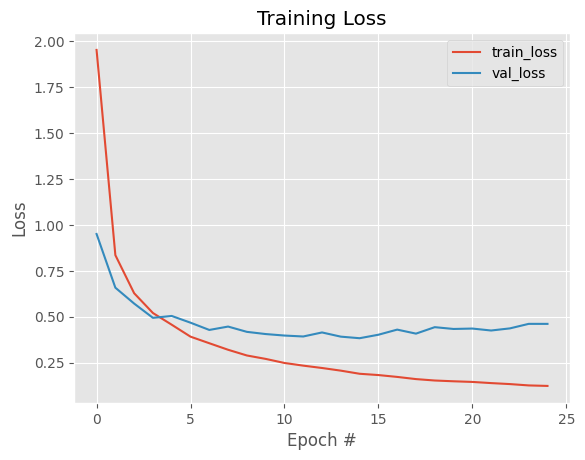

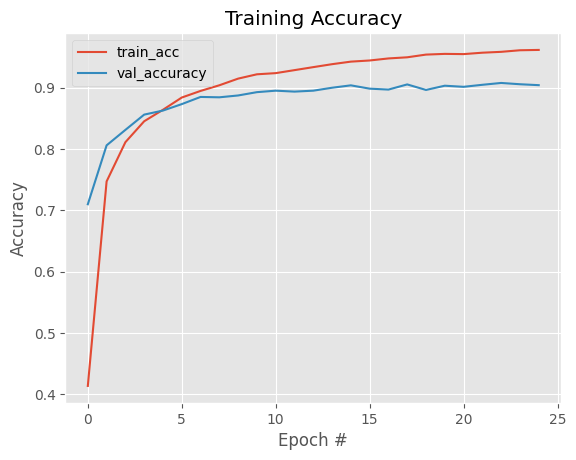

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.94      0.95      0.95       155
        down       0.91      0.88      0.89       155
       eight       0.92      0.89      0.90       155
        five       0.93      0.86      0.90       155
      follow       0.85      0.87      0.86       155
     forward       0.88      0.81      0.85       155
        four       0.82      0.82      0.82       155
          go       0.84      0.92      0.88       155
       learn       0.88      0.84      0.86       155
        left       0.95      0.92      0.93       155
        nine       0.92      0.92      0.92       155
          no       0.87      0.89      0.88       155
         off       0.94      0.93      0.94       155
          on       0.91      0.94      0.92       155
         one       0.95      0.92      0.94       155
       right       0.97      0.91      0.94       155
       seven       0.96      0.94      0.95       

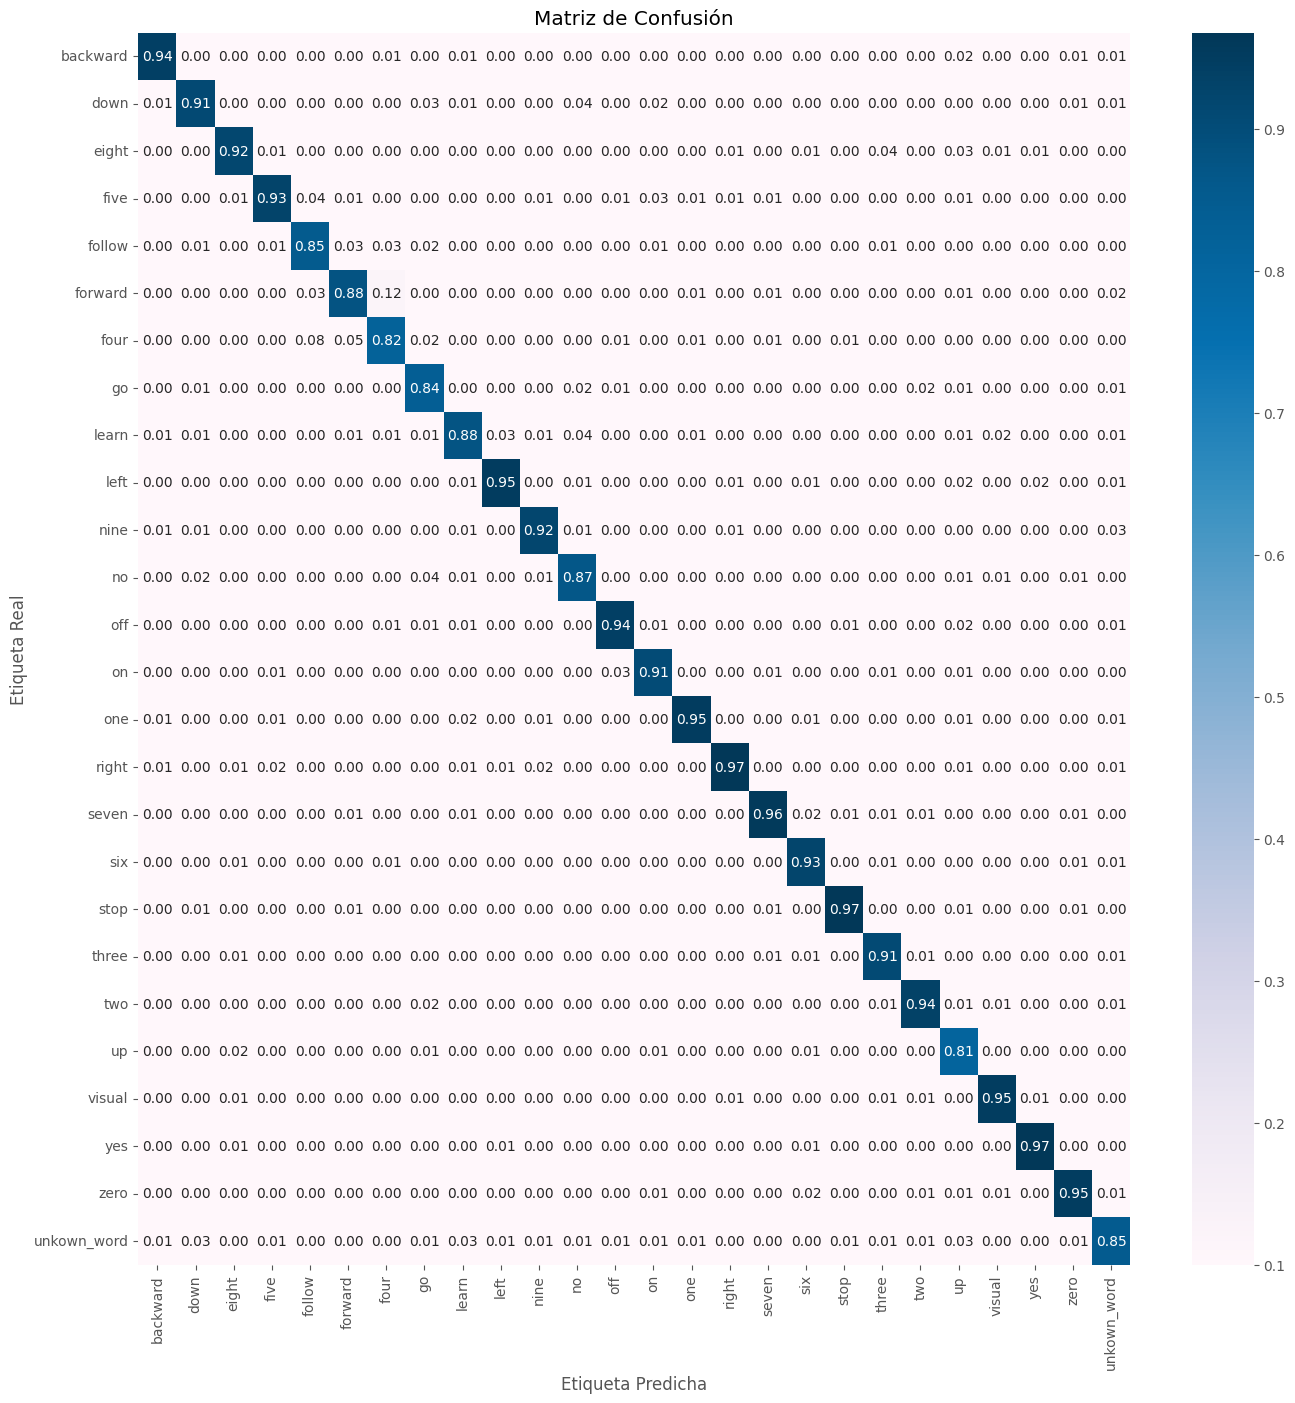

In [ ]:
mis = MetricsInfoShower(exp_b_gru_lme_0_05, h_exp_b_gru_lme_0_05, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b_gru_lme_0_06

In [ ]:
exp_b_gru_lme_0_06 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.4),
    GRU(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    GRU(32, return_sequences=False, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(n_classes , activation='softmax')
])

exp_b_gru_lme_0_06.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b_gru_lme_0_06.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b_gru_lme_0_06.csv'))

In [ ]:
y_train.shape

(32660, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b_gru_lme_0_06 = exp_b_gru_lme_0_06.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1511 - loss: 2.7948
Epoch 1: val_loss improved from inf to 1.07478, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_06.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.1512 - loss: 2.7942 - val_accuracy: 0.6649 - val_loss: 1.0748 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6532 - loss: 1.0973
Epoch 2: val_loss improved from 1.07478 to 0.72296, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_06.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.6533 - loss: 1.0970 - val_accuracy: 0.7703 - val_loss: 0.7230 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7529 - loss: 0.8037
Epoch 3: val_loss improved from 0.72296 to 0.61839, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_06.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7529 - loss: 0.8035 - val_accuracy: 0.8066 - val_loss: 0.6184 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8007 - loss: 0.6575
Epoch 4: val_loss improved from 0.61839 to 0.58292, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_06.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8008 - loss: 0.6575 - val_accuracy: 0.8360 - val_loss: 0.5829 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8317 - loss: 0.5705
Epoch 5: val_loss improved from 0.58292 to 0.46251, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_06.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.8318 - loss: 0.5705 - val_accuracy: 0.8655 - val_loss: 0.4625 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8515 - loss: 0.5024
Epoch 6: val_loss improved from 0.46251 to 0.46158, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_06.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8515 - loss: 0.5024 - val_accuracy: 0.8634 - val_loss: 0.4616 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8639 - loss: 0.4480
Epoch 7: val_loss improved from 0.46158 to 0.42201, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_06.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8639 - loss: 0.4479 - val_accuracy: 0.8772 - val_loss: 0.4220 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8808 - loss: 0.4006
Epoch 8: val_loss did not improve from 0.42201
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8808 - loss: 0.4006 - val_accuracy: 0.8787 - val_loss: 0.4311 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8888 - loss: 0.3733
Epoch 9: val_loss did not improve from 0.42201
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8888 - loss: 0.3733 - val_accuracy: 0.8772 - val_loss: 0.4428 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1019/1021 ━━━━━━━━━━━━━━━━━━

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9041 - loss: 0.3257 - val_accuracy: 0.8922 - val_loss: 0.3897 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9092 - loss: 0.3033
Epoch 12: val_loss did not improve from 0.38974
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9092 - loss: 0.3033 - val_accuracy: 0.8898 - val_loss: 0.3910 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9200 - loss: 0.2690
Epoch 13: val_loss did not improve from 0.38974
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9200 - loss: 0.2690 - val_accuracy: 0.8847 - val_loss: 0.4108 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1020/1021 ━━━━━━━━━━━━

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9408 - loss: 0.1953 - val_accuracy: 0.9012 - val_loss: 0.3883 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9428 - loss: 0.1835
Epoch 21: val_loss did not improve from 0.38828
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9428 - loss: 0.1835 - val_accuracy: 0.9015 - val_loss: 0.4204 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9453 - loss: 0.1819
Epoch 22: val_loss did not improve from 0.38828
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9453 - loss: 0.1819 - val_accuracy: 0.8994 - val_loss: 0.4313 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
1020/1021 ━━━━━━━━━━

In [ ]:
exp_b_gru_lme_0_06.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                         │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 63, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 386,192 (1.47 MB)

 Trainable params: 128,730 (502.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 257,462 (1005.71 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


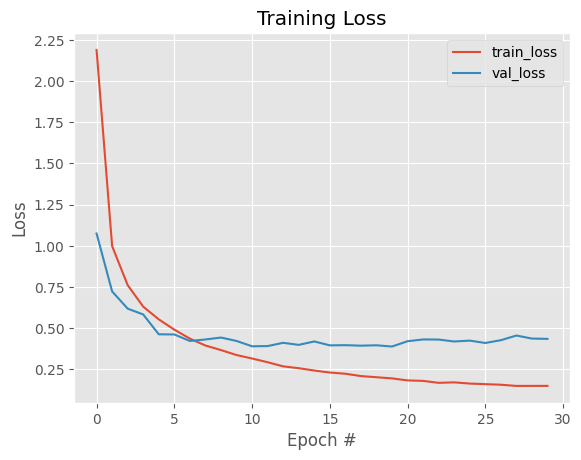

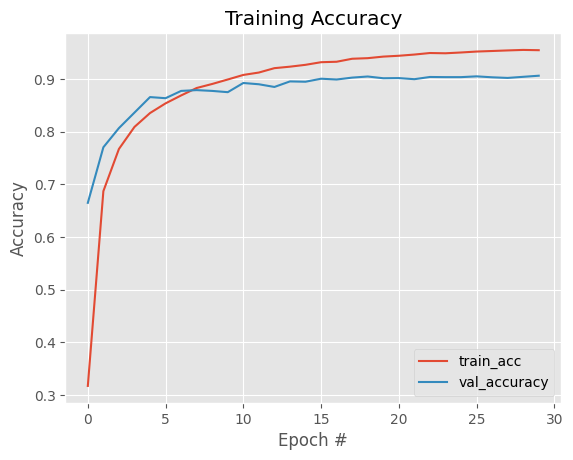

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.91      0.95      0.93       155
        down       0.89      0.87      0.88       155
       eight       0.94      0.94      0.94       155
        five       0.91      0.90      0.91       155
      follow       0.83      0.88      0.85       155
     forward       0.85      0.79      0.82       155
        four       0.81      0.83      0.82       155
          go       0.86      0.92      0.88       155
       learn       0.87      0.77      0.82       155
        left       0.92      0.90      0.91       155
        nine       0.96      0.92      0.94       155
          no       0.84      0.89      0.86       155
         off       0.95      0.91      0.93       155
          on       0.92      0.92      0.92       155
         one       0.91      0.94      0.92       155
       right       1.00      0.90      0.95       155
       seven       0.94      0.94      0.94       

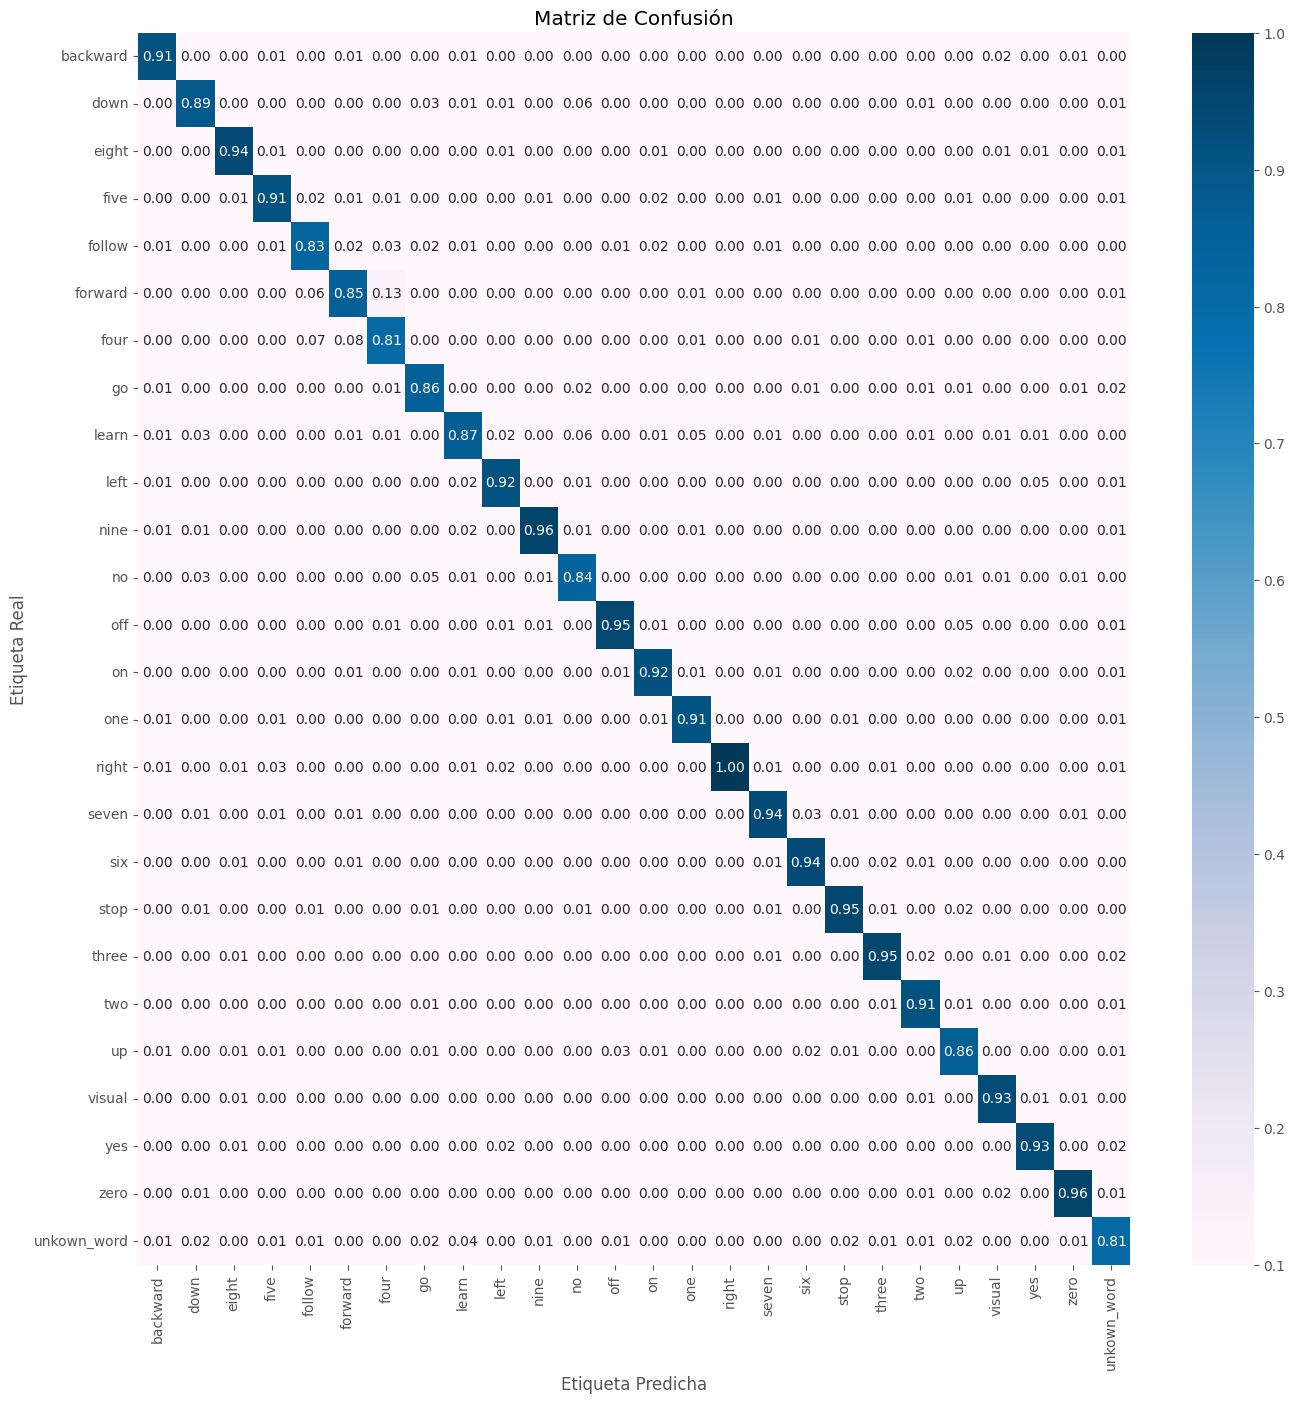

In [ ]:
mis = MetricsInfoShower(exp_b_gru_lme_0_06, h_exp_b_gru_lme_0_06, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b_gru_lme_0_07

In [ ]:
exp_b_gru_lme_0_07 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.4),
    GRU(64, return_sequences=True, activation='relu'),
    Dropout(0.4),
    GRU(32, return_sequences=False, activation='relu'),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_classes , activation='softmax')
])

exp_b_gru_lme_0_07.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b_gru_lme_0_07.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b_gru_lme_0_07.csv'))

In [ ]:
y_train.shape

(32660, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b_gru_lme_0_07 = exp_b_gru_lme_0_07.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0952 - loss: 2.9949
Epoch 1: val_loss improved from inf to 1.66247, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.0953 - loss: 2.9946 - val_accuracy: 0.4916 - val_loss: 1.6625 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4806 - loss: 1.6037
Epoch 2: val_loss improved from 1.66247 to 1.00992, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.4807 - loss: 1.6034 - val_accuracy: 0.6958 - val_loss: 1.0099 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6694 - loss: 1.0719
Epoch 3: val_loss improved from 1.00992 to 0.72726, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.6694 - loss: 1.0718 - val_accuracy: 0.7814 - val_loss: 0.7273 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7395 - loss: 0.8547
Epoch 4: val_loss improved from 0.72726 to 0.71599, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7395 - loss: 0.8547 - val_accuracy: 0.7790 - val_loss: 0.7160 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7749 - loss: 0.7394
Epoch 5: val_loss improved from 0.71599 to 0.62686, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.7749 - loss: 0.7394 - val_accuracy: 0.8060 - val_loss: 0.6269 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7963 - loss: 0.6615
Epoch 6: val_loss improved from 0.62686 to 0.56591, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7963 - loss: 0.6615 - val_accuracy: 0.8279 - val_loss: 0.5659 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8122 - loss: 0.6109
Epoch 7: val_loss did not improve from 0.56591
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.8122 - loss: 0.6109 - val_accuracy: 0.8225 - val_loss: 0.5739 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8280 - loss: 0.5486
Epoch 8: val_loss improved from 0.56591 to 0.54788, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.8280 - loss: 0.5485 - val_accuracy: 0.8318 - val_loss: 0.5479 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8394 - loss: 0.5179
Epoch 9: val_loss improved from 0.54788 to 0.53287, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8394 - loss: 0.5179 - val_accuracy: 0.8342 - val_loss: 0.5329 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8433 - loss: 0.4961
Epoch 10: val_loss improved from 0.53287 to 0.52668, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8433 - loss: 0.4961 - val_accuracy: 0.8363 - val_loss: 0.5267 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8607 - loss: 0.4495
Epoch 11: val_loss improved from 0.52668 to 0.49975, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8607 - loss: 0.4495 - val_accuracy: 0.8544 - val_loss: 0.4998 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8674 - loss: 0.4290
Epoch 12: val_loss improved from 0.49975 to 0.49747, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8674 - loss: 0.4290 - val_accuracy: 0.8592 - val_loss: 0.4975 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8774 - loss: 0.4094
Epoch 13: val_loss did not improve from 0.49747
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8774 - loss: 0.4093 - val_accuracy: 0.8673 - val_loss: 0.5020 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8845 - loss: 0.3825
Epoch 14: val_loss improved from 0.49747 to 0.45298, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_07.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8845 - loss: 0.3825 - val_accuracy: 0.8757 - val_loss: 0.4530 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8926 - loss: 0.3566
Epoch 15: val_loss did not improve from 0.45298
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.8926 - loss: 0.3566 - val_accuracy: 0.8757 - val_loss: 0.4653 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8957 - loss: 0.3410
Epoch 16: val_loss did not improve from 0.45298
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8957 - loss: 0.3410 - val_accuracy: 0.8748 - val_loss: 0.4778 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
1021/1021 ━━━━━━━━━━━

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8999 - loss: 0.3296 - val_accuracy: 0.8835 - val_loss: 0.4517 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9115 - loss: 0.3004
Epoch 19: val_loss did not improve from 0.45169
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9115 - loss: 0.3004 - val_accuracy: 0.8865 - val_loss: 0.4535 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9099 - loss: 0.3082
Epoch 20: val_loss did not improve from 0.45169
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9099 - loss: 0.3082 - val_accuracy: 0.8850 - val_loss: 0.4537 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
1020/1021 ━━━━━━━━━━

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.9140 - loss: 0.2942 - val_accuracy: 0.8907 - val_loss: 0.4308 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9188 - loss: 0.2701
Epoch 22: val_loss did not improve from 0.43077
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9188 - loss: 0.2701 - val_accuracy: 0.8886 - val_loss: 0.4400 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9193 - loss: 0.2752
Epoch 23: val_loss did not improve from 0.43077
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9193 - loss: 0.2752 - val_accuracy: 0.8925 - val_loss: 0.4374 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
1021/1021 ━━━━━━━━━━━

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9236 - loss: 0.2570 - val_accuracy: 0.8919 - val_loss: 0.4303 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9270 - loss: 0.2443
Epoch 27: val_loss did not improve from 0.43027
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9270 - loss: 0.2443 - val_accuracy: 0.8922 - val_loss: 0.4380 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9271 - loss: 0.2472
Epoch 28: val_loss did not improve from 0.43027
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9271 - loss: 0.2472 - val_accuracy: 0.8913 - val_loss: 0.4396 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
1021/1021 ━━━━━━━━━━━

In [ ]:
exp_b_gru_lme_0_07.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_13 (GRU)                         │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ (None, 63, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405,968 (1.55 MB)

 Trainable params: 135,322 (528.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,646 (1.03 MB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


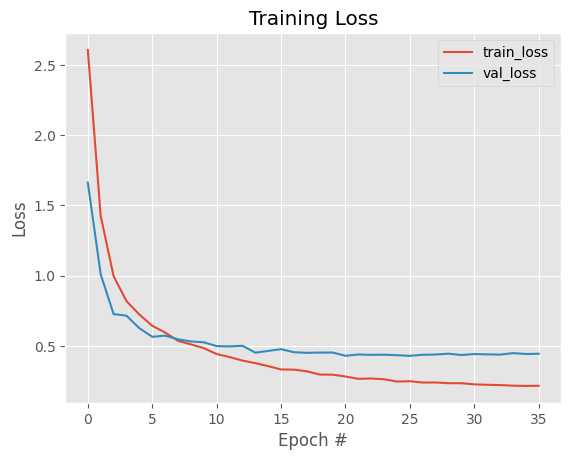

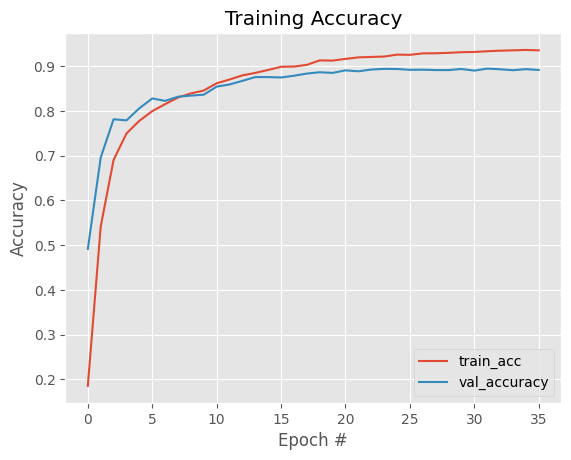

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.98      0.94      0.96       155
        down       0.96      0.87      0.92       155
       eight       0.92      0.91      0.92       155
        five       0.95      0.90      0.92       155
      follow       0.83      0.87      0.85       155
     forward       0.89      0.76      0.82       155
        four       0.77      0.86      0.81       155
          go       0.80      0.90      0.85       155
       learn       0.78      0.80      0.79       155
        left       0.90      0.92      0.91       155
        nine       0.96      0.86      0.91       155
          no       0.91      0.81      0.86       155
         off       0.96      0.91      0.93       155
          on       0.95      0.92      0.93       155
         one       0.91      0.92      0.91       155
       right       0.97      0.90      0.93       155
       seven       0.96      0.96      0.96       

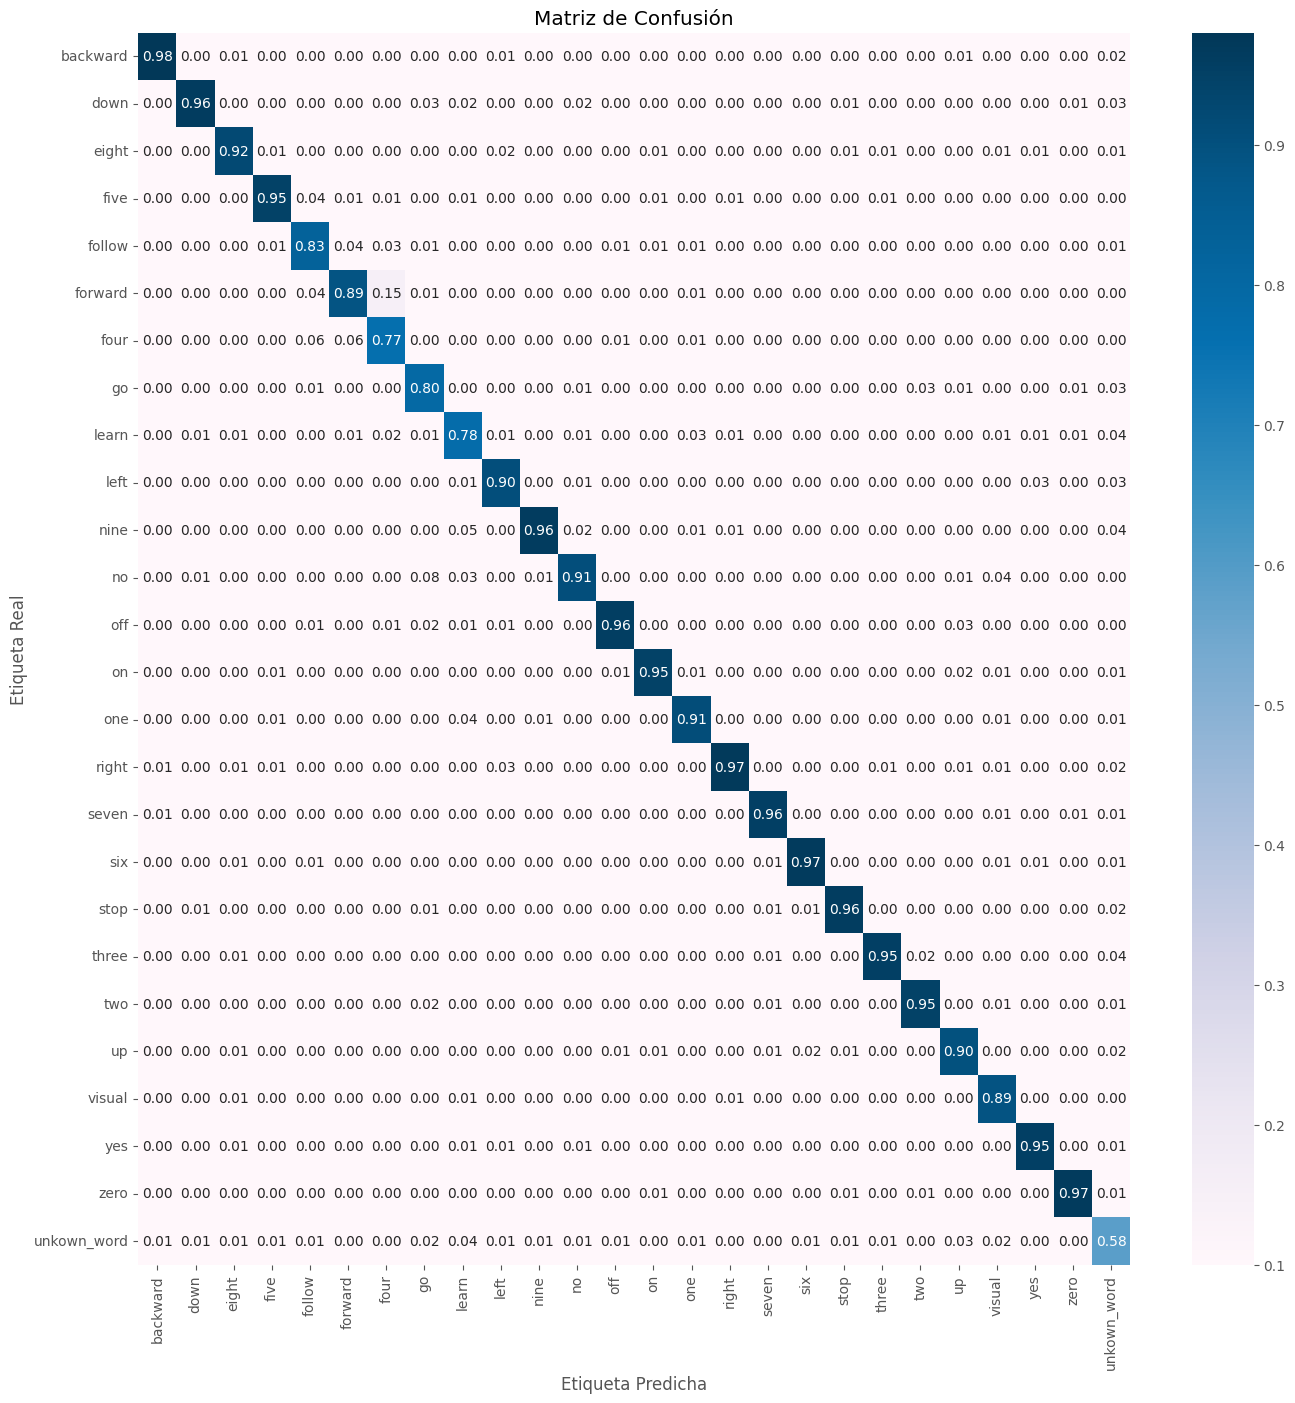

In [ ]:
mis = MetricsInfoShower(exp_b_gru_lme_0_07, h_exp_b_gru_lme_0_07, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b_gru_lme_0_09

In [ ]:
exp_b_gru_lme_0_09 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.5),
    GRU(128, return_sequences=True, activation='relu'),
    Dropout(0.5),
    GRU(128, return_sequences=False, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_classes , activation='softmax')
])

exp_b_gru_lme_0_09.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b_gru_lme_0_09.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b_gru_lme_0_09.csv'))

In [ ]:
y_train.shape

(32660, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b_gru_lme_0_09 = exp_b_gru_lme_0_09.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1196 - loss: 2.9447
Epoch 1: val_loss improved from inf to 1.14683, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_09.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.1198 - loss: 2.9441 - val_accuracy: 0.6553 - val_loss: 1.1468 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6483 - loss: 1.1428
Epoch 2: val_loss improved from 1.14683 to 0.77764, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_09.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6483 - loss: 1.1427 - val_accuracy: 0.7688 - val_loss: 0.7776 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7796 - loss: 0.7556
Epoch 3: val_loss improved from 0.77764 to 0.62050, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_09.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.7796 - loss: 0.7555 - val_accuracy: 0.8186 - val_loss: 0.6205 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8194 - loss: 0.6167
Epoch 4: val_loss improved from 0.62050 to 0.56343, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_09.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.8194 - loss: 0.6166 - val_accuracy: 0.8363 - val_loss: 0.5634 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8434 - loss: 0.5221
Epoch 5: val_loss improved from 0.56343 to 0.51747, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_09.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.8434 - loss: 0.5221 - val_accuracy: 0.8508 - val_loss: 0.5175 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8671 - loss: 0.4520
Epoch 6: val_loss improved from 0.51747 to 0.46752, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_09.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.8671 - loss: 0.4520 - val_accuracy: 0.8691 - val_loss: 0.4675 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8824 - loss: 0.4040
Epoch 7: val_loss improved from 0.46752 to 0.43194, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_09.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.8824 - loss: 0.4040 - val_accuracy: 0.8760 - val_loss: 0.4319 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8919 - loss: 0.3792
Epoch 8: val_loss improved from 0.43194 to 0.40823, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b_gru_lme_0_09.h5


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.8919 - loss: 0.3792 - val_accuracy: 0.8841 - val_loss: 0.4082 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9004 - loss: 0.3414
Epoch 9: val_loss did not improve from 0.40823
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.9004 - loss: 0.3414 - val_accuracy: 0.8865 - val_loss: 0.4166 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9063 - loss: 0.3196
Epoch 10: val_loss did not improve from 0.40823
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.9063 - loss: 0.3196 - val_accuracy: 0.8835 - val_loss: 0.4274 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1019/1021 ━━━━━━━━━━━━━━━

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.9177 - loss: 0.2876 - val_accuracy: 0.8958 - val_loss: 0.3890 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1019/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9267 - loss: 0.2536
Epoch 13: val_loss did not improve from 0.38895
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9267 - loss: 0.2536 - val_accuracy: 0.8883 - val_loss: 0.4226 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9262 - loss: 0.2499
Epoch 14: val_loss did not improve from 0.38895
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9262 - loss: 0.2499 - val_accuracy: 0.8964 - val_loss: 0.4190 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
1020/1021 ━━━━━━━━━━━━

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9410 - loss: 0.1927 - val_accuracy: 0.9048 - val_loss: 0.3784 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9468 - loss: 0.1837
Epoch 20: val_loss did not improve from 0.37837
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.9468 - loss: 0.1837 - val_accuracy: 0.9018 - val_loss: 0.4056 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
1020/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9462 - loss: 0.1765
Epoch 21: val_loss did not improve from 0.37837
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9462 - loss: 0.1765 - val_accuracy: 0.9033 - val_loss: 0.4137 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
1019/1021 ━━━━━━━━━━

In [ ]:
exp_b_gru_lme_0_09.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                         │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_17 (GRU)                         │ (None, 63, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_18 (GRU)                         │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 847,760 (3.23 MB)

 Trainable params: 282,586 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 565,174 (2.16 MB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


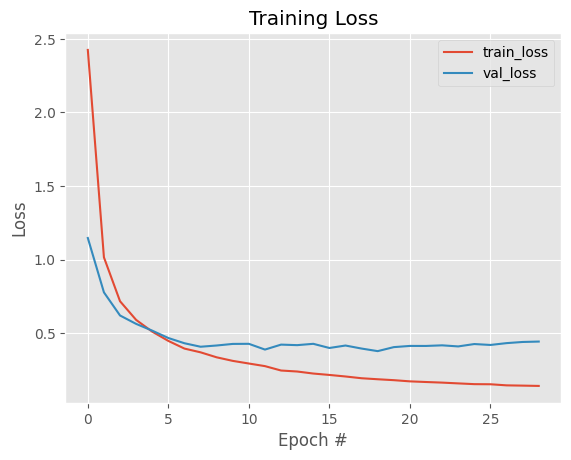

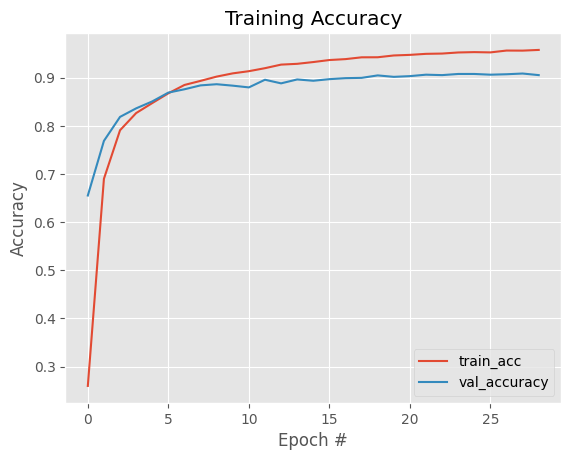

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.95      0.95      0.95       155
        down       0.95      0.81      0.87       155
       eight       0.90      0.90      0.90       155
        five       0.94      0.88      0.91       155
      follow       0.82      0.84      0.83       155
     forward       0.87      0.74      0.80       155
        four       0.76      0.90      0.82       155
          go       0.79      0.91      0.85       155
       learn       0.86      0.82      0.84       155
        left       0.95      0.88      0.92       155
        nine       0.95      0.87      0.91       155
          no       0.87      0.87      0.87       155
         off       0.90      0.94      0.91       155
          on       0.89      0.95      0.92       155
         one       0.94      0.93      0.94       155
       right       0.95      0.90      0.92       155
       seven       0.94      0.97      0.96       

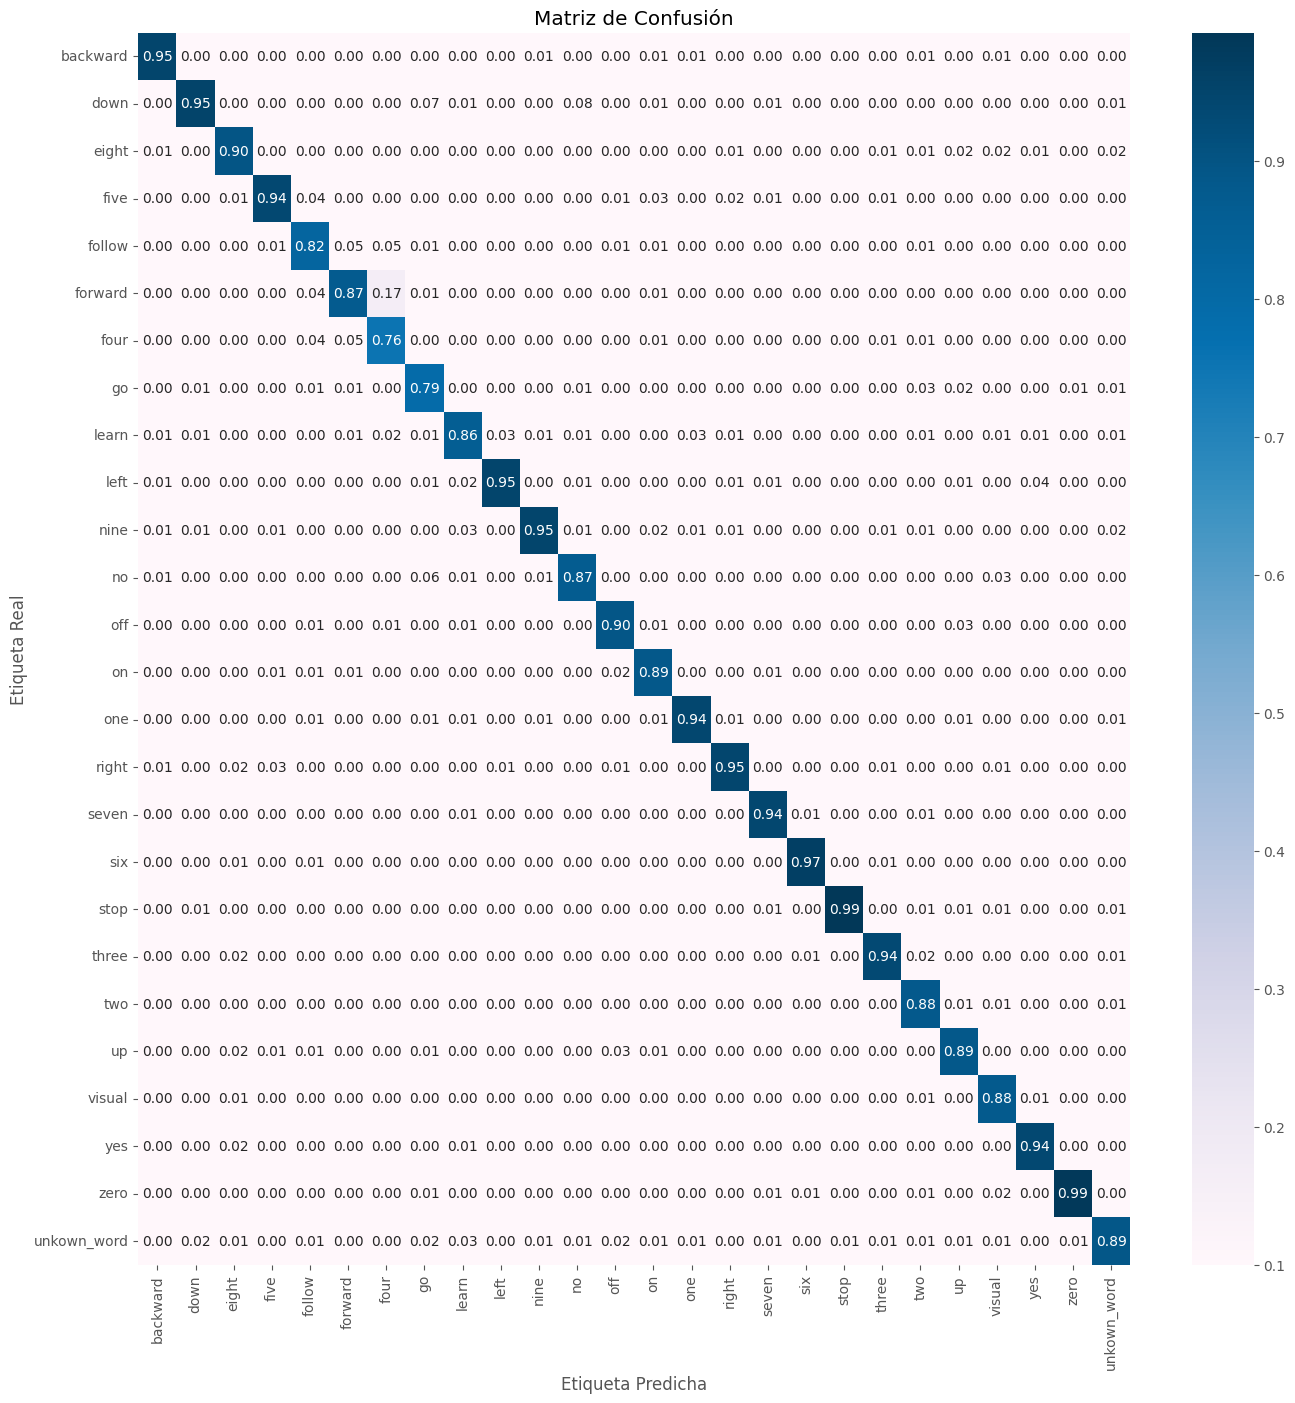

In [ ]:
mis = MetricsInfoShower(exp_b_gru_lme_0_09, h_exp_b_gru_lme_0_09, x_test, y_test, batch_size, classes)
mis.show_all()